# Notes about simulation:

# Import packages and set settings

In [2]:
%matplotlib inline
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import numpy as np
# import math
import pandas as pd
from scipy.integrate import odeint
# from scipy.integrate import solve_ivp
import os
import itertools
from scipy.optimize import fsolve

In [3]:
# plt.style.use("seaborn-whitegrid")
plt.rcParams['figure.figsize'] = [10.0, 8.0]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['grid.linestyle'] = '-'
plt.rcParams['legend.fontsize'] = 14
colors = [i['color'] for i in plt.rcParams['axes.prop_cycle']]

In [4]:
# sns.palplot(sns.husl_palette(10, l=.7))
# palette_husl = sns.husl_palette(10, l=.7)
# sns.set_palette(palette_husl)
# # palette_husl.as_hex()
# rocket = sns.color_palette("rocket", 5)#[::-1][:4]
# rocket = rocket.as_hex()

In [109]:
MAPK_palette = {0:'#323232', 50000:'#D3D3D3', 150000:'#8ace88', 250000:'#5ab769', 350000: '#319a50', 450000:'#117b38', 550000:'#005723',
                0:'#323232', 50:'#D3D3D3', 150:'#8ace88', 250:'#5ab769', 350: '#319a50', 450:'#117b38', 550:'#005723'}
MAP2K_palette = {0:'#323232', 50000:'#D3D3D3', 150000:'#84bcdb', 250000:'#5ab769', 350000: '#319a50', 450000:'#117b38', 550000:'#084082',
                 0:'#323232', 50:'#D3D3D3', 150:'#84bcdb', 250:'#5ab769', 350: '#319a50', 450:'#117b38', 550:'#084082'}
palettes = {0:MAPK_palette,
           1:MAP2K_palette,
           2:MAPK_palette,
           3:MAPK_palette,
           4:MAPK_palette }


# Supporting Functions

In [6]:
def molarity_conversion(molecules):
    Na = 6.02214076*10**23
    cell_volume = 44
    return molecules/(Na*cell_volume*10**-15)*1000000

def gather_simulated_data(folder, gen, runs, top_plotting):
    mse = []
    params_from_file = []

    empty_data = 0
    for loaded_data in pathlib.Path(folder).glob('*.pickled'):
        if os.path.getsize(loaded_data) > 0:
            with open(loaded_data, 'rb') as f:
                new_data = pickle.load(f)
                mse.append(np.asarray(new_data[0]))
                params_from_file.append(np.asarray(new_data[1]))
        else:
            empty_data += 1

    top = round((runs-empty_data)*top_plotting)
    plt_top = round((runs-empty_data)*top_plotting)      

    new_params = []
    last_mses = []
    for i in range(len(params_from_file)):
        new_params.append(params_from_file[i][gen])
        last_mses.append(mse[i][gen])
    last_mses = np.asarray(last_mses)
#     last_mses = last_mses
    new_params = np.asarray(new_params)
    new_params = new_params.T

    idx_top = last_mses.argsort()[:top]

    top_params = [([new_params[i][x] for i in range(len(new_params))]) for x in idx_top]
    # top_params = []
    # for idx in idx_top:
    #     top_params.append(params_from_file[idx][100])

    print('Best MSE: ' + str(np.min([mse[idx][gen] for idx in idx_top])))
    print('Mean MSE of top 5%: ' + str(np.mean([mse[idx][gen] for idx in idx_top])))
    return idx_top, top_params, top, plt_top, new_params, params_from_file, mse, last_mses


    
def plt_mses_gen(gen,mse):
    plt.clf()
    fig, (ax3) = plt.subplots(1, 1, figsize=(12,8))
    colors2 = sns.color_palette("Greys", 20)[10:]
    pal2 = sns.set_palette(colors2)
    ax3.set_xlabel('Generation', fontsize=20)
    for idx in idx_top:
        ax3.semilogy([x for x in range(gen)], mse[idx][:gen])
    ax3.yaxis.grid(True)
    ax3.set_ylabel('SSE', fontsize=20)
    ax3.set_xlim([0,gen])
#     ax3.set_ylim([10**3,10**5])
    plt.show()
    

def plot_param_ranges(labelnames, diff, minimums, df_top_params_log_M, colors=None):
    plt.rcParams['figure.figsize'] = [12.0, 8.0]

    if colors:
        pal3 = sns.set_palette(colors)

    with sns.axes_style("whitegrid"):
        plt.bar(range(0,len(labelnames)),height=diff,bottom=minimums,align='center',tick_label=labelnames, color='#DCDCDC',alpha = 0.5)
        x = sns.swarmplot(x='param',y='vals', data = df_top_params_log_M)
        x.set_xticklabels(labelnames,rotation=45)
    #     ax.set_yscale("log")
    #     ax.set_ylim(0.00001,100000)
    #     ax4.set_xticks(locs)
    #     plt.xticklabels(labelnames, fontsize=18, rotation=90)
        plt.xlabel('Parameters', fontsize=20)
        plt.ylabel('Learned parameter values (base 10)', fontsize=20)
    #     ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
        plt.show()
        

def plot_mses(labelnames, mses, top_p, colors, title):
    mses = [x.copy() for x in mses]
    top = len(mses[0])*top_p
    top_mses = [np.sort(x)[:int(top)] for x in mses]
    df_mses = pd.DataFrame(top_mses).T
    df_mses.columns = labelnames
    df_mses_M = df_mses.melt(var_name='model', value_name='vals')

    pal = sns.set_palette(colors)
    with sns.axes_style("whitegrid"):
        x = sns.swarmplot(x='model',y='vals', data = df_mses_M)
        x.set_xticklabels(labelnames,rotation=45)
    #     ax.set_yscale("log")
    #     ax.set_ylim(0.00001,100000)
    #     ax4.set_xticks(locs)
    #     plt.xticklabels(labelnames, fontsize=18, rotation=90)
        plt.xlabel('Models', fontsize=20)
        plt.ylabel('SMSE', fontsize=20)
    #     ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
        plt.title('SMSE of the top '+ str(int(top_p*100)) + '% of parameter sets')
#     plt.savefig("C:/Users/sksuzuki/Documents/Research/presentations/lab_meetings/Figures/"+title+".png",dpi=300)
#         plt.show()

# def get_synthdata(data, ):
    
def get_synth_data_params(opt_data_mapk,wt_data_synth,top_params,num):
    opt_tps = list(itertools.chain.from_iterable(opt_data_mapk.values()))
    smse = []
    for params in top_params[:num]:
        smse_total = 0
        #     arr_params_IP = convert_individual(learned_params, arr_conversion_matrix)

        for sig, tps, MAPK_wt_data in zip(list(opt_data_mapk.keys()), list(opt_data_mapk.values()), wt_data_synth):
            params_constants_sig = params_constants[:-1]+[sig]
            for fxn in [simulate_wt_experiment]:
                data = fxn(initals, params_constants_sig, params, tps)
                active = data[:,2]/params_constants[2]*100
        #         print(MAPK_wt_data, active)
                error_active = ((MAPK_wt_data - active)**2).mean()
                smse_total += error_active
                if sig == 550000:
                    data = fxn(initals, params_constants_sig, params, mapk_time)
                    map2k = data[:,1]/params_constants[1]*100
                    if any(x > 20 for x in map2k):
    #                     print(map2k)
                        continue
                    else:
                        smse_total += 5000
        smse.append(smse_total)
    idx_synth_param = sorted(range(len(smse)), key=lambda k: smse[k])
    return top_params[idx_synth_param[0]]


## Function to plot param behaviors

In [200]:
def plt_param_behaviors(top_params, plt_top, params_constants, initials, gen, doses, time, param, mapk_wt_data=None, mapk_t100a_data=None, mapk_time=None):
    plt.clf()
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18,4))


    # plot 1
#     title_text = 'Gen ' + str(gen) + ' best fits to WT'
    title_text = 'Wild-type MAPK Simulations'
    ax1.set_title(title_text, fontsize=20)
    ax1.set_xlabel('Time (min)', fontsize=16)
    ax1.set_ylabel('% ppHog1', fontsize=16)
    plt.rc('xtick', labelsize=14) 
    plt.rc('ytick', labelsize=14)
    palette = palettes.get(param)

    if mapk_wt_data:
        for sig, wt_data in zip(doses, mapk_wt_data):
            ax1.plot(mapk_time, wt_data, 'o', markersize=10, color=palette.get(sig), label = str(int(sig/1000))+'mM KCl')
#     ax1.legend()

    # plot 2
#     title_text = 'Gen ' + str(gen) +  ' best fits to T100A + inhib'
    title_text = 'Inhibited MAPK Simulations'#'Best fits to kinase dead mutant dose data'
    ax2.set_title(title_text, fontsize=20)
    ax2.set_xlabel('Time (min)', fontsize=16)
    ax2.set_ylabel('% pppHog1', fontsize=16)

    if mapk_t100a_data:
        for sig, t100a_data in zip(doses, mapk_t100a_data):
#             print(len(t100a_data))
#             if sig == 0:
#                 continue
#                 print(mapk_time_t100a_long)
#                 ax2.plot(mapk_time_t100a_long, t100a_data, '^', mew=2, markersize=10, color=palette.get(sig))
#             else:
            ax2.plot(mapk_time, t100a_data, '^', mew=2, markersize=10, color=palette.get(sig))

#     ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')    

    # plot evolutionary algorithm data on plots 1 and 2:
#     print(params_constants[1])

    if param == 3:
#         ax1.set_ylim(0,150000)
        dt = 0.1
        steps = 5401
        time = np.linspace(0,dt*steps,steps)
    else:
        ax1.set_ylim(0,105)
        ax2.set_ylim(0,105)

    if params_constants[-1] == 0:
        ax1.set_ylim(50,105)

    for sig in doses:
        for params in top_params[:plt_top]:
#         for sig in doses:
            glyss = 0
            ss_data = run_ss(initials, params_constants, params, glyss)
            glyss = ss_data[3]
#             print(ss_data)
#             print(glyss)
            data = simulate_wt_experiment(ss_data, params_constants, sig, params,  glyss, time)
            if data[3].any() < 0:
                continue
            else:
                active = data[:,param]/params_constants[param]*100
    #             print(data[:,param])
                ax1.plot(time, active, color=palette.get(sig))

#             if sig == 0: 
#                 time = np.linspace(0,300,3001)
#             else: 
#                 time = np.linspace(0,60,601)
                data = simulate_t100a_experiment(ss_data, params_constants, sig, params, glyss, time)
                active = data[:,param]/params_constants[param]*100
#             print(active)
                ax2.plot(time, active, '--', color=palette.get(sig))

#     ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')
#     plt.savefig("C:/Users/sksuzuki/Documents/Research/figures/simulations/Hog1.png",dpi=300,bbox_inches='tight')
    plt.show()
    
def plt_ramp_behaviors(top_params, plt_top, params_constants, initials, gen, time, param, hog1_ramp_data=None, mapk_ramp_time=None):
    fig, (ax1) = plt.subplots(1, 1, figsize=(9,4))
    
    ax1.plot(mapk_ramp_time, hog1_ramp_data[0], 'o', color='gray')
    
    for params in top_params[:plt_top]:
#         for sig in doses:
            glyss = 0 
            ss_data = run_ss(initials, params_constants, params, glyss)
            glyss = ss_data[3]
            data = simulate_ramp_experiment(ss_data, params_constants, params, glyss, time)
            active = data[:,param]/params_constants[param]*100
#             print(data[:,param])
            ax1.plot(time, active)
    plt.show()



In [8]:
def signal_ramp_special(t_step):
    sig = 0
    if t_step >= .001:
        sig = 250000
    if t_step >= 20:
        sig = 550000
#     if t_step >= 40:
#         sig = 600000
    return sig
# plt.plot(time,[signal_ramp_special(x) for x in time])

# Load data to fit to

In [9]:
wt_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/WT'
t100a_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/T100A'
pbs2_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/Pbs2'
pbs2_t100a_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/Pbs2_T100A'
# sho1DD_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/sho1DD'
# ssk1D_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/ssk1D'
hog1_ramp_folder =  'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/ramp_1'
# pbs2_ramp_folder =  'C:/Users/sksuzuki/Desktop/killdevil/data_pbs2/MAPK activation/pulse_pbs2'
ptpD_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/ptpD'

def load_csv_data(folder):
    data = []
    for csv in pathlib.Path(folder).glob('*.csv'):
        f_data = pd.read_csv(csv)
        time = f_data['Time'].tolist()
        f_data=f_data.set_index('Time')
        f_data = f_data.mean(axis=1)
        f_data = f_data.tolist()
        data.append(f_data)
    return time, data

mapk_time, mapk_wt_data = load_csv_data(wt_folder)
mapk_time, mapk_t100a_data = load_csv_data(t100a_folder)
mapk_time, map2k_wt_data = load_csv_data(pbs2_folder)
mapk_time, map2k_t100a_data = load_csv_data(pbs2_t100a_folder)
mapk_time, mapk_ptp_data = load_csv_data(ptpD_folder)
# mapk_time, sho1_wt_data = load_csv_data(ssk1D_folder)
# mapk_time, sln1_wt_data = load_csv_data(sho1DD_folder)
mapk_ramp_time, hog1_ramp_data = load_csv_data(hog1_ramp_folder)
# mapk_pulse_time, pbs2_pulse_data = load_csv_data(pbs2_pulse_folder)

# hog1_pulse_data = hog1_pulse_data[0]
# pbs2_pulse_data = pbs2_pulse_data[0]


scorefxn_data = [mapk_wt_data, mapk_t100a_data, map2k_wt_data, map2k_t100a_data, hog1_ramp_data]
scorefxn_time = [mapk_time,mapk_ramp_time]

In [10]:
# exclude far points
mapk_t100a_data = [mapk_t100a_data[0][:9]] + mapk_t100a_data[1:]

In [11]:
dt = 0.1
steps = 601
time = np.linspace(0,dt*steps,steps)

# idx_closest_time_points = get_closest_tps(mapk_time,time)

# Mutual inhibition

##  190708_glyss_b2_kb_ptpFIT

**Notes** 


### Inputs

In [50]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/from/fit_to_ramp/190708_glyss_b2_kb_ptpFIT/'
gen = 1000
runs = 2000

MAP3K = 0
MAP2K = 0
MAPK = 0
X = 0
PTP = molarity_conversion(118)

MAP3K_t = molarity_conversion(701)
MAP2K_t = molarity_conversion(2282)
MAPK_t = molarity_conversion(5984)
PTP_t = molarity_conversion(118)

# s = [0, 50000, 150000, 250000, 350000, 450000, 550000]


labelnames = [    'beta_2', 'alpha_1', 'alpha_2', 'kb', 'k1', 'k3', 'k5', 's7', 'k9', 'k2', 'k4', 'k6', 'd8', 'K_1', 'K_3', 'K_5', 'K_9', 'K_2', 'K_4', 'K_6', 'K_10' #21
 ] #21

minimums = [-4, -4,  -4,
    -4, -4, -4, -4, -4,
    -4, -4, -4, -4, -4,
    -4, -4, -4, -4,
    -4, -4, -4, -4]

maximums = [ 4, 4, 4,
    4, 4, 4, 4, 4,
    4, 4, 4, 4, 4,
    4, 4, 4, 4,
    4, 4, 4, 4]

diff = np.asarray(maximums)-np.asarray(minimums)

# fb = 1
# t100a_fb = 0

initials = [MAP3K, MAP2K, MAPK, X, PTP]
# params_constants = [MAP3K_t, MAP2K_t, MAPK_t, PTP_t] 
params_constants = [MAP3K_t, MAP2K_t, MAPK_t, 1, PTP_t] 
doses = [0, 50000, 150000, 250000, 350000, 450000, 550000]
map2k_doses = [150000, 550000]
mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

labels = ['MAP3K','MAP2K','MAPK','gly','PTP']

In [36]:
def glyss_b2_a1_1D_kb(initials,t,total_protein,sig,params, glyss):
    MAP3K, MAP2K, MAPK, gly, PTP = initials
    MAP3K_t, MAP2K_t, MAPK_t, _, PTP_t = total_protein
    beta_2, alpha_1, alpha_2, kb, k1, k3, k5, s7, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10 = params #21

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    PTP_I = PTP_t-PTP
    
    signal = sig + glyss - gly + kb
    if t == 0:
        print(signal) 

    # dMAP3K = (((sig*k1+kb)/(1+gly/beta_3))*MAP3K_I)/(K_1+MAP3K_I) - ((k2+beta_2*MAPK)*MAP3K/(K_2+MAP3K))
    dMAP3K = ((k1*(sig + glyss - gly + kb))*MAP3K_I)/(K_1+MAP3K_I) - ((k2+beta_2*MAPK)*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - ((k6+alpha_2*PTP)*MAPK)/(K_6+MAPK)
    dgly = s7*MAPK - d8*gly
    dPTP = (k9*PTP_I/(K_9+PTP_I)) - ((alpha_1*MAPK)*PTP)/(K_10+PTP)

    return dMAP3K, dMAP2K, dMAPK, dgly, dPTP

def run_wt_ss(inits, total_protein, learned_params, glyss):
    ss = fsolve(glyss_b2_a1_1D_kb, inits, args=(0,total_protein, 0, learned_params, glyss))
    return ss

def simulate_wt_experiment(inits, total_protein, sig, learned_params, glyss, time):
    odes = odeint(glyss_b2_a1_1D_kb, inits, time, args=(total_protein, sig, learned_params, glyss))
    return odes

def glyss_b2_a1_1D_kb_ramp(initials,t,total_protein,params,glyss):
    MAP3K, MAP2K, MAPK, gly, PTP = initials
    MAP3K_t, MAP2K_t, MAPK_t, _, PTP_t = total_protein
    beta_2, alpha_1, alpha_2, kb, k1, k3, k5, s7, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10  = params #21

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    PTP_I = PTP_t-PTP

    sig = signal_ramp_special(t)

    dMAP3K = ((k1*(sig + glyss - gly + kb))*MAP3K_I)/(K_1+MAP3K_I) - ((k2+beta_2*MAPK)*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - ((k6+alpha_2*PTP)*MAPK)/(K_6+MAPK)
    dgly = s7*MAPK - d8*gly
    dPTP = (k9*PTP_I/(K_9+PTP_I)) - ((alpha_1*MAPK)*PTP)/(K_10+PTP)

    return dMAP3K, dMAP2K, dMAPK, dgly, dPTP


def simulate_t100a_experiment(inits, total_protein, sig, learned_params, glyss, time):
    beta_2, alpha_1, alpha_2, kb, k1, k3, k5, s7, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10 = learned_params #21
    learned_params = beta_2, 0, alpha_2, kb, k1, k3, k5, 0, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10
    #solve odes:
    odes = odeint(glyss_b2_a1_1D_kb, inits, time, args=(total_protein, sig, learned_params, glyss))
    return odes

# def simulate_nopos_experiment(inits, total_protein, sig, learned_params, time):
#     # parameters to be learned - inits
#     # parameters to be kept constant - params_constants
#     # parameters to be learned - learned_params
#     beta_3, alpha_1, alpha_2, kb, k1, k3, k5, s7, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10 = learned_params #21
#     learned_params = beta_3, 0, alpha_2, kb, k1, k3, k5, s7, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10
#     #solve odes:
#     odes = odeint(b3_a1_1D, inits, time, args=(total_protein, sig, learned_params))
#     return odes


def simulate_ramp_experiment(inits, total_protein, learned_params,glyss, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params

    #solve odes:
    odes = odeint(glyss_b2_a1_1D_kb_ramp, inits, time, args=(total_protein, learned_params,glyss))
    return odes

def signal_ramp_special(t_step):
    sig = 0
    if t_step >= .001:
        sig = 250000
    if t_step >= 20:
        sig = 550000
    return sig

In [51]:
def run_ss(inits, total_protein, learned_params, glyss):
#     top_params_a1_1D
    ss = fsolve(glyss_b2_a1_1D_kb, inits, args=(0,total_protein, 0, learned_params, glyss))
    return ss

# def run_t100a_ss(inits, total_protein, learned_params):
#     beta_3, alpha_1, alpha_2, kb, k1, k3, k5, s7, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10 = learned_params #21
#     learned_params = beta_3, 0, alpha_2, kb, k1, k3, k5, 0, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10
#     ss = fsolve(b3_a1_1D, inits, args=(0,total_protein, 0, learned_params))
#     return ss

### Gather simulated data

In [18]:
idx_top, top_params_a1_1D, top, plt_top, new_params, params_from_file, mse_a1_1D, last_mses_a1_1D = gather_simulated_data(folder, gen, runs, 0.01)
df_top_params = pd.DataFrame(top_params_a1_1D)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M = df_top_params_log.melt(var_name='param', value_name='vals')

Best MSE: 5826.3724232179375
Mean MSE of top 5%: 9212.975456849103


### Plot

In [74]:
for params in top_params_a1_1D[:10]:
    odeint(glyss_b2_a1_1D_kb, initials, time, args=(params_constants, 150000, params, glyss))
# simulate_wt_experiment(ss_data, params_constants, sig, params,  glyss, time)

NameError: name 'glyss' is not defined

1012.6620522253174
1012.6620522253174
1012.6620522253174
1012.6620522253174
1012.6620522253174
1012.6620522253174
1012.6620522104163
1012.6620522253174
1001.5910715631015
1012.1099811764144
1012.6620522253174
1012.6620522253174
1012.6620522253174
1012.6620522104163
1012.6620522253174
1001.5910715631015
1012.1099811764144
1012.4052856655147
1012.5384584255393
1012.6013751770718
1012.6319878306439
1012.647088349723
1012.6545873753644
0.0
1012.6620522253174
1012.6620522253174
9309.521433847933
9309.521433847933
9309.521433847933
9309.521433847933
9309.521433847933
9309.521433847933
9309.521433833032
9309.521433847933
9309.521433847864
9309.521433847867
9309.521433847995
9309.521433847955
9309.521433847958
9309.521433847933
9309.521433847936
9309.521433847924
9309.521433847925
9309.521433847924
9309.521433847925
9309.521433847922
9309.521433847924
9309.52143384792
9309.52143384792
9309.521433847918
9309.521433847918
9309.521433847916
9309.52143384792
9309.521433847915
9309.521433847922
930

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


51012.662052225314
9309.521433847933
9309.521433847933
9309.521433847933
9309.521433847933
9309.521433847933
9309.521433847933
9309.521433833032
9309.521433847933
9309.521433847864
9309.521433847867
9309.521433847995
9309.521433847955
9309.521433847958
9309.521433847933
9309.521433847936
9309.521433847924
9309.521433847925
9309.521433847924
9309.521433847925
9309.521433847922
9309.521433847924
9309.52143384792
9309.52143384792
9309.521433847918
9309.521433847918
9309.521433847916
9309.52143384792
9309.521433847915
9309.521433847922
9309.52143384792
9309.52143384792
9309.52143384792
9309.52143384792
9309.52143384792
9309.521433847916
9309.521433847915
9309.521433847916
9309.521433847915
9309.521433847915
9309.521433847916
9309.521433847916
9309.521433847916
9309.521433847916
9309.521433847916
9309.521433847916
9309.521433847915
9309.521433847913
9309.521433847915
9309.521433847915
9309.521433847915
9309.521433847915
9309.521433847915
9309.521433847915
9309.521433847915
9309.521433847913

159309.52143384793
1012.6620522253174
1012.6620522253174
1012.6620522253174
1012.6620522253174
1012.6620522253174
1012.6620522253174
1012.6620522104163
1012.6620522253174
1001.5910715631015
1012.1099811764144
1012.6620522253174
1012.6620522253174
1012.6620522253174
1012.6620522104163
1012.6620522253174
1001.5910715631015
1012.1099811764144
1012.4052856655147
1012.5384584255393
1012.6013751770718
1012.6319878306439
1012.647088349723
1012.6545873753644
0.0
251012.66205222532
251012.66205222532
9309.521433847933
9309.521433847933
9309.521433847933
9309.521433847933
9309.521433847933
9309.521433847933
9309.521433833032
9309.521433847933
9309.521433847864
9309.521433847867
9309.521433847995
9309.521433847955
9309.521433847958
9309.521433847933
9309.521433847936
9309.521433847924
9309.521433847925
9309.521433847924
9309.521433847925
9309.521433847922
9309.521433847924
9309.52143384792
9309.52143384792
9309.521433847918
9309.521433847918
9309.521433847916
9309.52143384792
9309.521433847915
93

1012.6620522253174
1012.6620522253174
1012.6620522253174
1012.6620522253174
1012.6620522253174
1012.6620522104163
1012.6620522253174
1001.5910715631015
1012.1099811764144
1012.6620522253174
1012.6620522253174
1012.6620522253174
1012.6620522104163
1012.6620522253174
1001.5910715631015
1012.1099811764144
1012.4052856655147
1012.5384584255393
1012.6013751770718
1012.6319878306439
1012.647088349723
1012.6545873753644
0.0
551012.6620522253
551012.6620522253
9309.521433847933
9309.521433847933
9309.521433847933
9309.521433847933
9309.521433847933
9309.521433847933
9309.521433833032
9309.521433847933
9309.521433847864
9309.521433847867
9309.521433847995
9309.521433847955
9309.521433847958
9309.521433847933
9309.521433847936
9309.521433847924
9309.521433847925
9309.521433847924
9309.521433847925
9309.521433847922
9309.521433847924
9309.52143384792
9309.52143384792
9309.521433847918
9309.521433847918
9309.521433847916
9309.52143384792
9309.521433847915
9309.521433847922
9309.52143384792
9309.52

<Figure size 864x576 with 0 Axes>

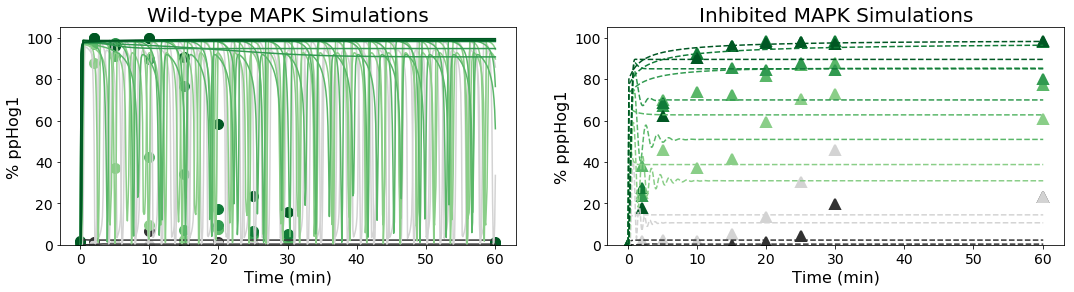

In [75]:
plt_param_behaviors(top_params_a1_1D, 2, params_constants, initials, 5000, doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time)
# plt.savefig("C:/Users/sksuzuki/Documents/Research/figures/simulations/hog1.png",dpi=150,bbox_inches='tight')

808.8290940747194
8.291568862582336e-11
9781.25080951156
5.163470986307459
372209.80429238034
0.16024214856080649


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1200.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:2

402.3144738017116
6.10289379261936
9.477075401655789
0.26316323442574635
808.8290940747194
8.291568862582336e-11
9781.25080951156
5.163470986307459
372209.80429238034
0.16024214856080649
402.3144738017116
6.10289379261936
9.477075401655789
0.26316323442574635
808.8290940747194
8.291568862582336e-11
9781.25080951156
5.163470986307459
372209.80429238034
0.16024214856080649
402.3144738017116
6.10289379261936
9.477075401655789
0.26316323442574635


<Figure size 720x576 with 0 Axes>

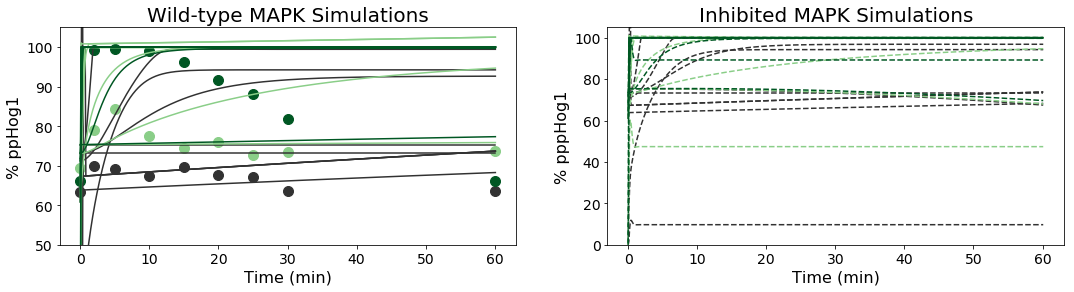

In [53]:
plt_param_behaviors(top_params_a1_1D, 10, [MAP3K_t, MAP2K_t, MAPK_t, 1, 0], initials, 5000, [0]+map2k_doses, time, 2, mapk_ptp_data, None, mapk_time)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


<Figure size 720x576 with 0 Axes>

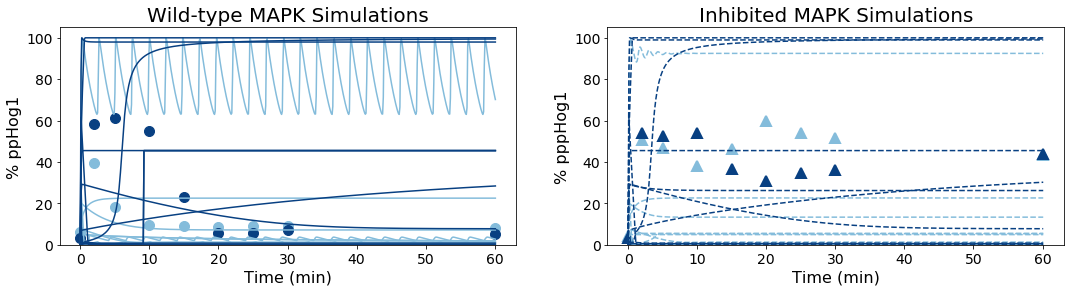

In [43]:
plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, map2k_doses, time, 1, map2k_wt_data, map2k_t100a_data, mapk_time)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1200.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

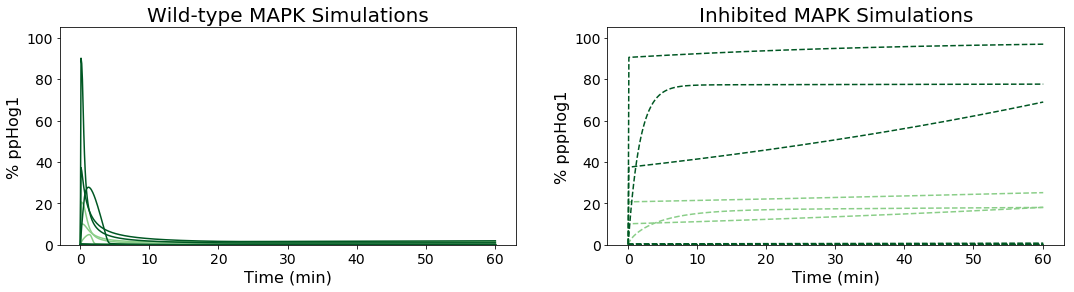

In [24]:
plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, map2k_doses, time, 0)

In [ ]:
plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, map2k_doses, time, 3)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1200.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

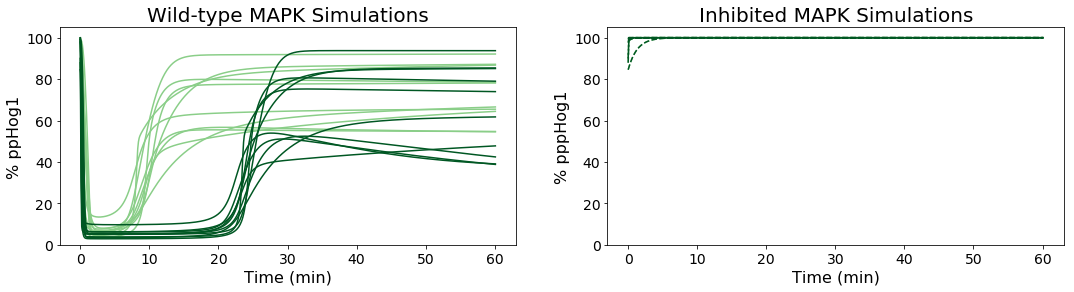

In [25]:
plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, map2k_doses, time, 4)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


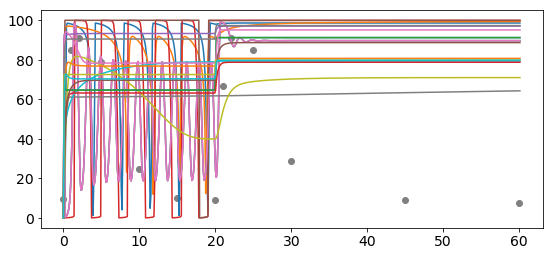

In [63]:
plt_ramp_behaviors(top_params_a1_1D, plt_top, params_constants, initials, gen, time, 2, hog1_ramp_data, mapk_ramp_time)

<Figure size 720x576 with 0 Axes>

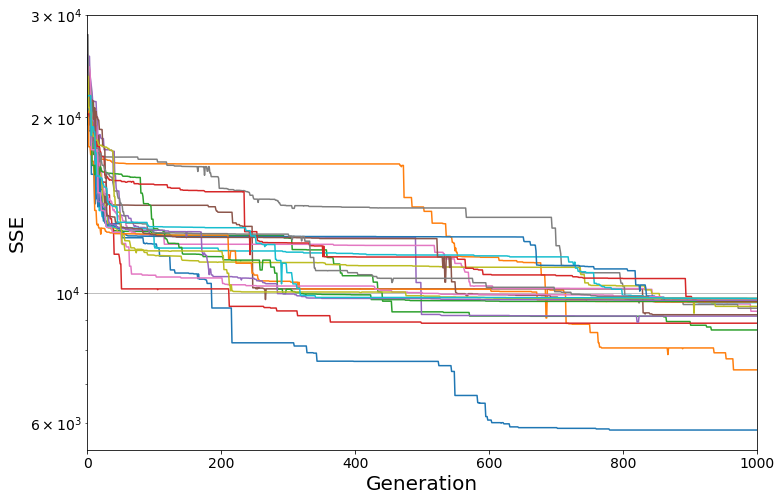

In [64]:
plt_mses_gen(gen,mse_a1_1D)

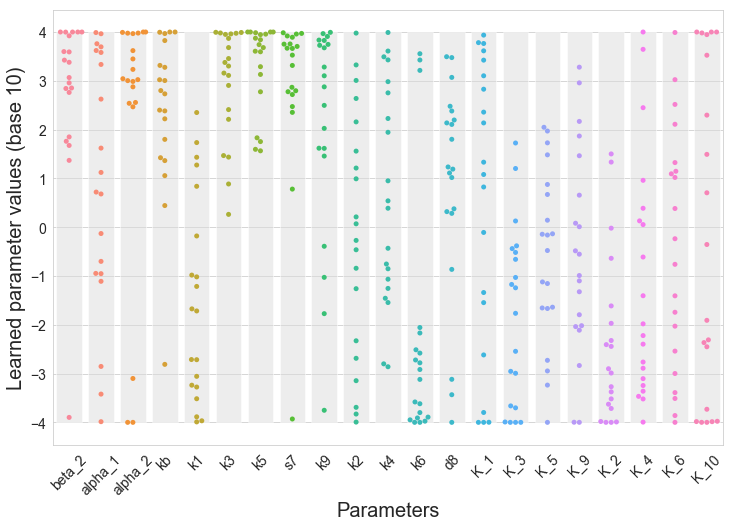

In [67]:
    # positive 3db7d6
    # negative ee9537
    # hog1 ? 38bf85 or 94ddaa

colors = ['#3c3c3c','#3c3c3c','#3c3c3c']*7 #+ rocket[::-1][:4] + rocket[::-1][:4]+ rocket[::-1][:3]+ rocket[::-1][:3]

plot_param_ranges(labelnames, diff, minimums, df_top_params_log_M)

## 190717_glyss_b2_kb_ptpFIT

**Notes** 


### Inputs

In [178]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/from/fit_to_ramp/190717_glyss_b2_kb_ptpFIT/'
gen = 1000
runs = 2000

MAP3K = 0
MAP2K = 0
MAPK = 0
X = 0
PTP = molarity_conversion(118)

MAP3K_t = molarity_conversion(701)
MAP2K_t = molarity_conversion(2282)
MAPK_t = molarity_conversion(5984)
PTP_t = molarity_conversion(118)



labelnames = ['beta_2', 'alpha_1', 'alpha_2', 'kb','k1', 'k3', 'k5', 's7', 'k9', 'k2', 'k4', 'k6', 'd8', 'K_1', 'K_3', 'K_5', 'K_9', 'K_2', 'K_4', 'K_6', 'K_10'
                ]

minimums = [
    -4, -4, -4, -4,-4,-4, -4, -4,-4,
    -4, -4, -4, -4,
    -4, -4, -4,-4,
    -4, -4, -4,-4]

maximums = [ 
    4, 4, 4, 4,4,4, 4,4,4,
    4, 4, 4, 4,
    4, 4, 4,4,
    4, 4, 4,4]

diff = np.asarray(maximums)-np.asarray(minimums)

# fb = 1
# t100a_fb = 0

initials = [MAP3K, MAP2K, MAPK, X, PTP]
# params_constants = [MAP3K_t, MAP2K_t, MAPK_t, PTP_t] 
params_constants = [MAP3K_t, MAP2K_t, MAPK_t, 1, PTP_t] 
doses = [0, 50, 150, 250, 350, 450, 550]
map2k_doses = [150, 550]
mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

labels = ['MAP3K','MAP2K','MAPK','gly','PTP']

In [179]:
if len(labelnames) == len(diff):
    print('Params and labels match')
    print(len(labelnames))
else:
    print(len(labelnames))
    print(len(diff))

Params and labels match
21


In [180]:
def glyss_b2_a1_1D_kb(initials,t,total_protein,sig,params, glyss):
    MAP3K, MAP2K, MAPK, gly, PTP = initials
    MAP3K_t, MAP2K_t, MAPK_t, _, PTP_t = total_protein
    beta_2, alpha_1, alpha_2, kb, k1, k3, k5, s7, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10 = params #21

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    PTP_I = PTP_t-PTP

    # dMAP3K = (((sig*k1+kb)/(1+gly/beta_3))*MAP3K_I)/(K_1+MAP3K_I) - ((k2+beta_2*MAPK)*MAP3K/(K_2+MAP3K))
    dMAP3K = ((kb + k1*(sig + glyss - gly))*MAP3K_I)/(K_1+MAP3K_I) - ((k2+beta_2*MAPK)*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - ((k6+alpha_2*PTP)*MAPK)/(K_6+MAPK)
    dgly = s7*MAPK - d8*gly
    dPTP = (k9*PTP_I/(K_9+PTP_I)) - ((alpha_1*MAPK)*PTP)/(K_10+PTP)

    return dMAP3K, dMAP2K, dMAPK, dgly, dPTP

def run_wt_ss(inits, total_protein, learned_params, glyss):
    ss = fsolve(glyss_b2_a1_1D_kb, inits, args=(0,total_protein, 0, learned_params, glyss))
    return ss

def simulate_wt_experiment(inits, total_protein, sig, learned_params, glyss, time):
    odes = odeint(glyss_b2_a1_1D_kb, inits, time, args=(total_protein, sig, learned_params, glyss))
    return odes

def glyss_b2_a1_1D_kb_ramp(initials,t,total_protein,params,glyss):
    MAP3K, MAP2K, MAPK, gly, PTP = initials
    MAP3K_t, MAP2K_t, MAPK_t, _, PTP_t = total_protein
    beta_2, alpha_1, alpha_2, kb, k1, k3, k5, s7, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10  = params #21

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    PTP_I = PTP_t-PTP

    sig = signal_ramp_special(t)

    dMAP3K = ((kb + k1*(sig + glyss - gly))*MAP3K_I)/(K_1+MAP3K_I) - ((k2+beta_2*MAPK)*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - ((k6+alpha_2*PTP)*MAPK)/(K_6+MAPK)
    dgly = s7*MAPK - d8*gly
    dPTP = (k9*PTP_I/(K_9+PTP_I)) - ((alpha_1*MAPK)*PTP)/(K_10+PTP)

    return dMAP3K, dMAP2K, dMAPK, dgly, dPTP


def simulate_t100a_experiment(inits, total_protein, sig, learned_params, glyss, time):
    beta_2, alpha_1, alpha_2, kb, k1, k3, k5, s7, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10 = learned_params #21
    learned_params = beta_2, 0, alpha_2, kb, k1, k3, k5, 0, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10
    #solve odes:
    odes = odeint(glyss_b2_a1_1D_kb, inits, time, args=(total_protein, sig, learned_params, glyss))
    return odes


def simulate_ramp_experiment(inits, total_protein, learned_params,glyss, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params

    #solve odes:
    odes = odeint(glyss_b2_a1_1D_kb_ramp, inits, time, args=(total_protein, learned_params,glyss))
    return odes

def signal_ramp_special(t_step):
    sig = 0
    if t_step >= .001:
        sig = 250000
    if t_step >= 20:
        sig = 550000
    return sig

In [181]:
def run_ss(inits, total_protein, learned_params, glyss):
    ss = fsolve(glyss_b2_a1_1D_kb, inits, args=(0,total_protein, 0, learned_params, glyss))#/total_protein*100
    return ss

# def run_t100a_ss(inits, total_protein, learned_params):
#     beta_3, alpha_1, alpha_2, kb, k1, k3, k5, s7, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10 = learned_params #21
#     learned_params = beta_3, 0, alpha_2, kb, k1, k3, k5, 0, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10
#     ss = fsolve(b3_a1_1D, inits, args=(0,total_protein, 0, learned_params))
#     return ss

### Gather simulated data

In [182]:
idx_top, top_params_a1_1D, top, plt_top, new_params, params_from_file, mse_a1_1D, last_mses_a1_1D = gather_simulated_data(folder, gen, runs, 0.01)
df_top_params = pd.DataFrame(top_params_a1_1D)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M = df_top_params_log.melt(var_name='param', value_name='vals')

Best MSE: 6456.225143859484
Mean MSE of top 5%: 8451.650196778972


### Plot

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 864x576 with 0 Axes>

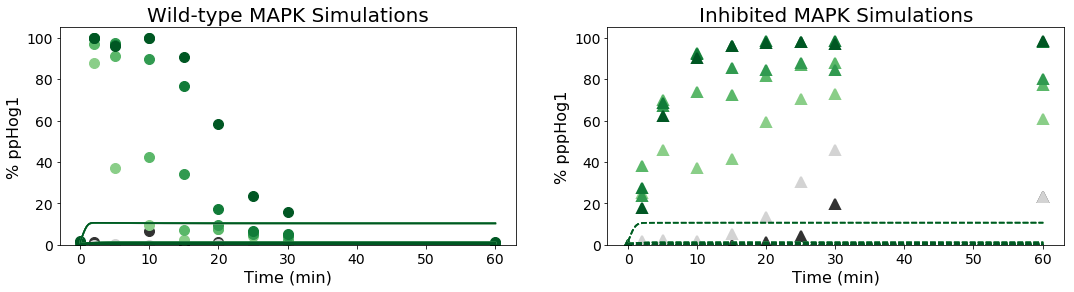

In [183]:
plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 1000, doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time)
# plt.savefig("C:/Users/sksuzuki/Documents/Research/figures/simulations/hog1.png",dpi=150,bbox_inches='tight')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1200.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 864x576 with 0 Axes>

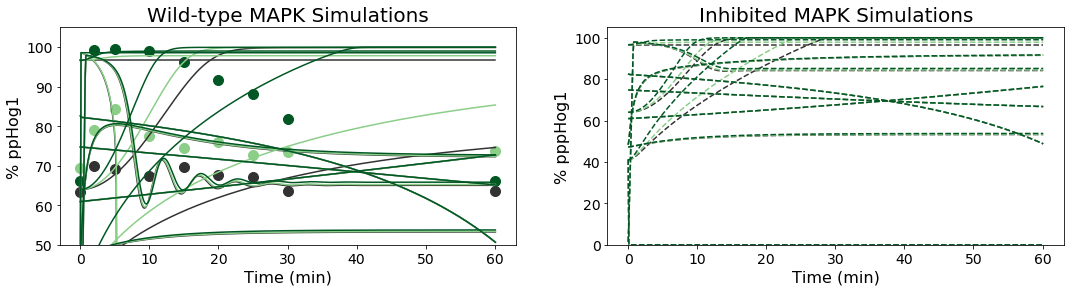

In [184]:
plt_param_behaviors(top_params_a1_1D, 10, [MAP3K_t, MAP2K_t, MAPK_t, 1, 0], initials, 5000, [0]+map2k_doses, time, 2, mapk_ptp_data, None, mapk_time)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 864x576 with 0 Axes>

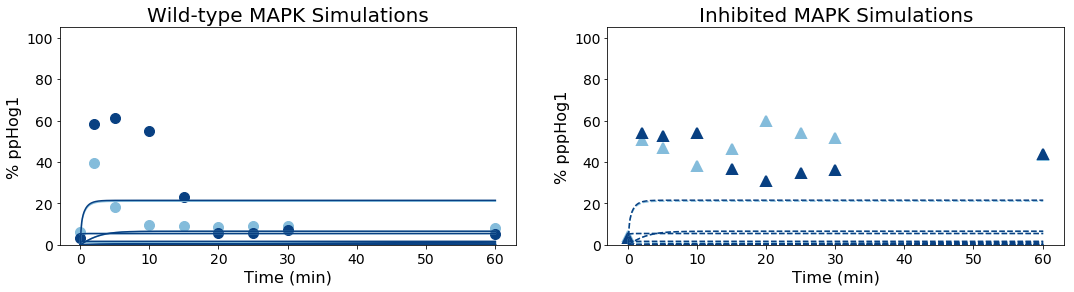

In [185]:
plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, map2k_doses, time, 1, map2k_wt_data, map2k_t100a_data, mapk_time)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 864x576 with 0 Axes>

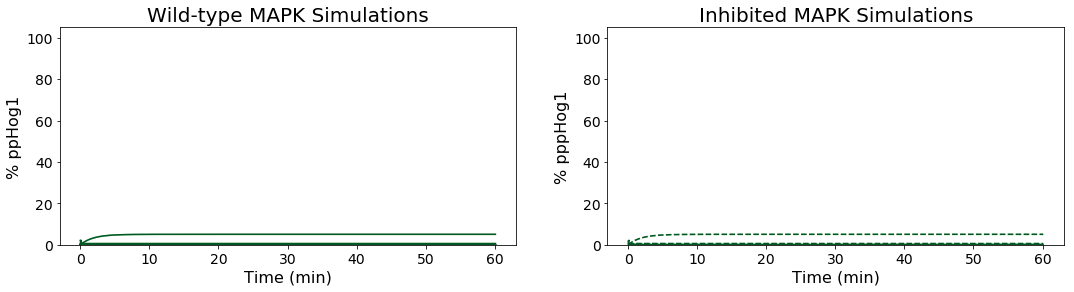

In [186]:
plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, map2k_doses, time, 0)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 864x576 with 0 Axes>

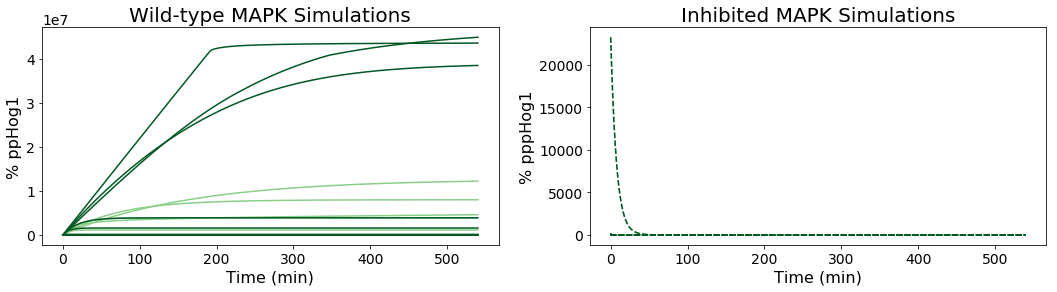

In [67]:
plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, map2k_doses, time, 3)

In [ ]:
# plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, map2k_doses, time, 4)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


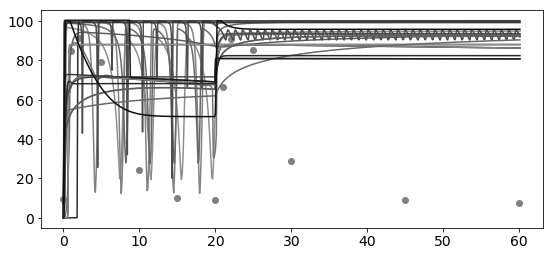

In [68]:
plt_ramp_behaviors(top_params_a1_1D, plt_top, params_constants, initials, gen, time, 2, hog1_ramp_data, mapk_ramp_time)

<Figure size 864x576 with 0 Axes>

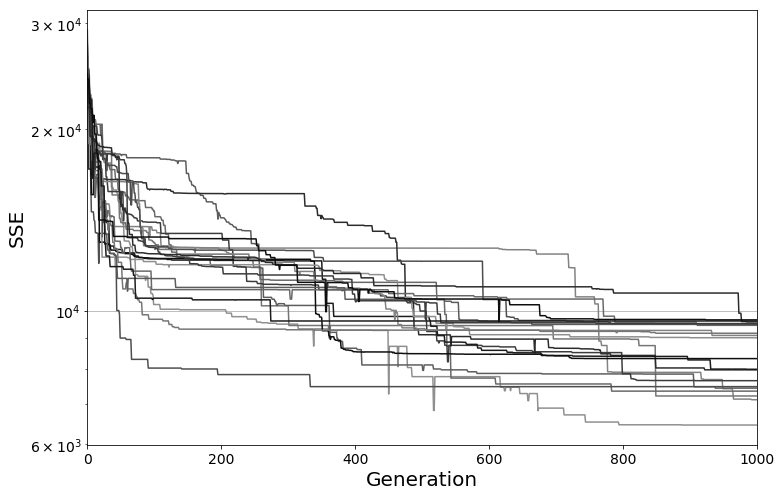

In [69]:
plt_mses_gen(gen,mse_a1_1D)

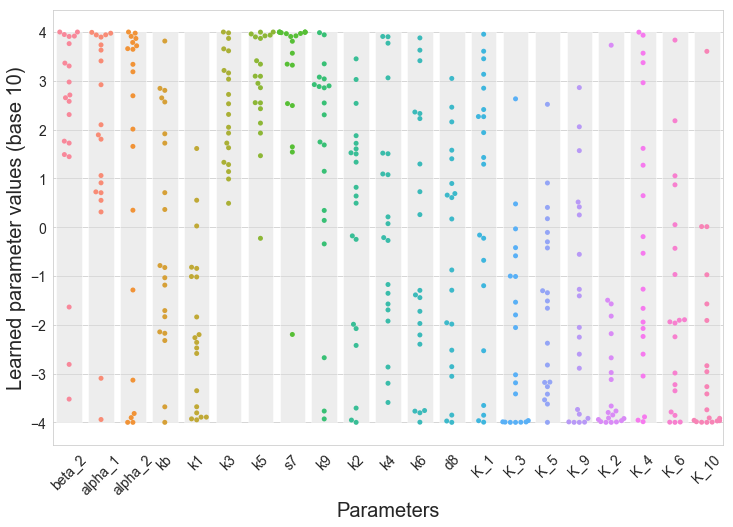

In [70]:
    # positive 3db7d6
    # negative ee9537
    # hog1 ? 38bf85 or 94ddaa

colors = ['#3c3c3c','#3c3c3c'] #+ rocket[::-1][:4] + rocket[::-1][:4]+ rocket[::-1][:3]+ rocket[::-1][:3]

plot_param_ranges(labelnames, diff, minimums, df_top_params_log_M)

##  190802_glyss_a1_kb_ptpFIT

**Notes** 


### Inputs

In [216]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/from/fit_to_ramp/190802_glyss_a1_kb/'
gen = 1000
runs = 2000

MAP3K = 0
MAP2K = 0
MAPK = 0
X = 0
PTP = molarity_conversion(118)

MAP3K_t = molarity_conversion(701)
MAP2K_t = molarity_conversion(2282)
MAPK_t = molarity_conversion(5984)
PTP_t = molarity_conversion(118)

labelnames = [    'alpha_1', 'kb', 'k1', 'k3', 'k5', 's7', 'k2', 'k4', 'k6', 'd8', 'K_1', 'K_3', 'K_5', 'K_2', 'K_4', 'K_6' #16

                ]

minimums = [-4, -4,
    -4, -4, -4, -4, -4,
    -4, -4, -4, -4, -4,
    -4, -4, -4, -4]

maximums = [ 4, 4,
    4, 4, 4, 4, 4,
    4, 4, 4, 4, 4,
    4, 4, 4, 4]


diff = np.asarray(maximums)-np.asarray(minimums)

# fb = 1
# t100a_fb = 0

initials = [MAP3K, MAP2K, MAPK, X]
# params_constants = [MAP3K_t, MAP2K_t, MAPK_t, PTP_t] 
params_constants = [MAP3K_t, MAP2K_t, MAPK_t, 1] 
doses = [0, 50, 150, 250, 350, 450, 550]
map2k_doses = [150, 550]
mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

labels = ['MAP3K','MAP2K','MAPK','gly']

In [ ]:
if len(labelnames) == len(diff):
    print('Params and labels match')

In [ ]:
def glyss_a1_kb_1D(initials,t,total_protein,sig,params, glyss):
    MAP3K, MAP2K, MAPK, gly = initials
    MAP3K_t, MAP2K_t, MAPK_t, _ = total_protein
    alpha_1, kb, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6 = params #16

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    # PTP_I = PTP_t-PTP
        

    # dMAP3K = (((sig*k1+kb)/(1+gly/beta_3))*MAP3K_I)/(K_1+MAP3K_I) - ((k2+beta_2*MAPK)*MAP3K/(K_2+MAP3K))
    dMAP3K = ((kb + k1*(sig + glyss - gly))*MAP3K_I)/(K_1+MAP3K_I) - ((k2)*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K+alpha_1*MAPK)*MAPK_I)/(K_5+MAPK_I)) - (k6*MAPK)/(K_6+MAPK)
    dgly = s7*MAPK - d8*gly
    # dPTP = (k9*PTP_I/(K_9+PTP_I)) - ((alpha_1*MAPK)*PTP)/(K_10+PTP)

    return dMAP3K, dMAP2K, dMAPK, dgly

def run_wt_ss(inits, total_protein, learned_params, glyss):
    ss = fsolve(glyss_a1_kb_1D, inits, args=(0,total_protein, 0, learned_params, glyss))
    return ss

def simulate_wt_experiment(inits, total_protein, sig, learned_params, glyss, time):
    odes = odeint(glyss_a1_kb_1D, inits, time, args=(total_protein, sig, learned_params, glyss))
    return odes


def simulate_t100a_experiment(inits, total_protein, sig, learned_params, glyss, time):
    alpha_1, kb, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6 = learned_params #21
    learned_params = 0, kb, k1, k3, k5, 0, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6
    #solve odes:
    odes = odeint(glyss_a1_kb_1D, inits, time, args=(total_protein, sig, learned_params, glyss))
    return odes

def b3_a1_1D_ramp(initials, t, total_protein, params, glyss):
    MAP3K, MAP2K, MAPK, gly = initials
    MAP3K_t, MAP2K_t, MAPK_t, _ = total_protein
    alpha_1, kb, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6 = params #21

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    PTP_I = PTP_t-PTP

    sig = signal_ramp_special(t)
    
    dMAP3K = ((kb + k1*(sig + glyss - gly))*MAP3K_I)/(K_1+MAP3K_I) - ((k2)*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K+alpha_1*MAPK)*MAPK_I)/(K_5+MAPK_I)) - (k6*MAPK)/(K_6+MAPK)
    dgly = s7*MAPK - d8*gly

    return dMAP3K, dMAP2K, dMAPK, dgly

def simulate_ramp_experiment(inits, total_protein, learned_params,glyss, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params

    #solve odes:
    odes = odeint(b3_a1_1D_ramp, inits, time, args=(total_protein, learned_params, glyss))
    return odes

def signal_ramp_special(t_step):
    sig = 0
    if t_step >= .001:
        sig = 250
    if t_step >= 20:
        sig = 550
    return sig

In [217]:
def run_ss(inits, total_protein, learned_params, glyss):
    ss = fsolve(glyss_a1_kb_1D, inits, args=(0,total_protein, 0, learned_params, glyss))#/total_protein*100
    return ss

# def run_t100a_ss(inits, total_protein, learned_params):
#     beta_3, alpha_1, alpha_2, kb, k1, k3, k5, s7, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10 = learned_params #21
#     learned_params = beta_3, 0, alpha_2, kb, k1, k3, k5, 0, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10
#     ss = fsolve(b3_a1_1D, inits, args=(0,total_protein, 0, learned_params))
#     return ss

### Gather simulated data

In [218]:
idx_top, top_params_a1_1D, top, plt_top, new_params, params_from_file, mse_a1_1D, last_mses_a1_1D = gather_simulated_data(folder, gen, runs, 0.01)
df_top_params = pd.DataFrame(top_params_a1_1D)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M = df_top_params_log.melt(var_name='param', value_name='vals')

Best MSE: 986.1746477608923
Mean MSE of top 5%: 1290.0541538058958


### Plot

<Figure size 864x576 with 0 Axes>

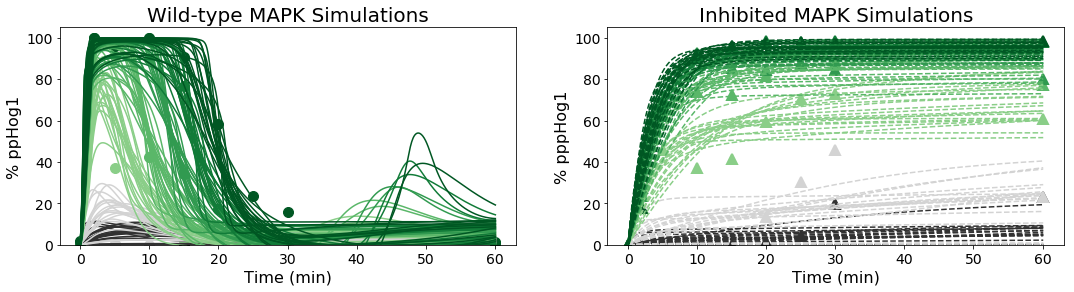

In [219]:
# MAPK
plt_param_behaviors(top_params_a1_1D, 20, params_constants, initials, 1000, doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time)
# plt.savefig("C:/Users/sksuzuki/Documents/Research/figures/simulations/hog1.png",dpi=150,bbox_inches='tight')

In [146]:
# plt_param_behaviors(top_params_a1_1D, 10, [MAP3K_t, MAP2K_t, MAPK_t, 1], initials, 5000, [0]+map2k_doses, time, 2, mapk_ptp_data, None, mapk_time)

<Figure size 864x576 with 0 Axes>

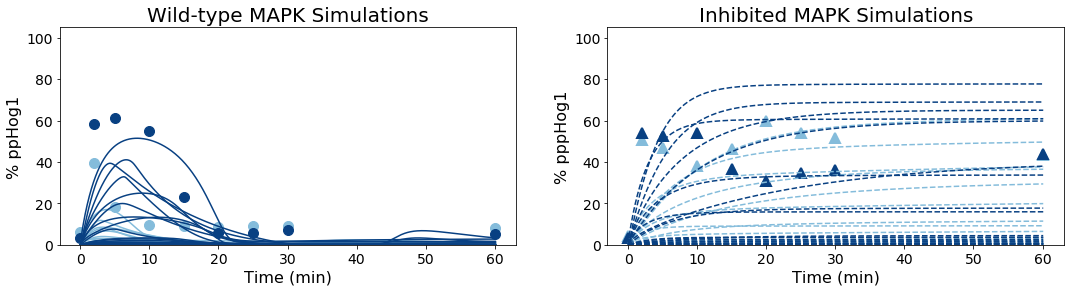

In [220]:
#MAP2K
plt_param_behaviors(top_params_a1_1D, 20, params_constants, initials, 5000, map2k_doses, time, 1, map2k_wt_data, map2k_t100a_data, mapk_time)

<Figure size 864x576 with 0 Axes>

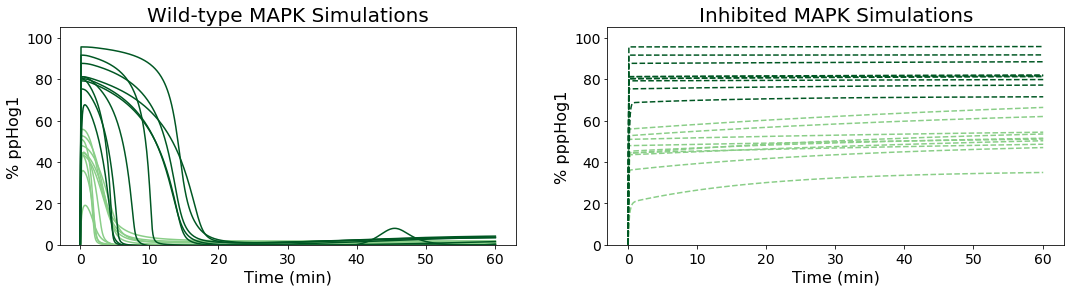

In [221]:
# MAP3K
plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, map2k_doses, time, 0)

<Figure size 864x576 with 0 Axes>

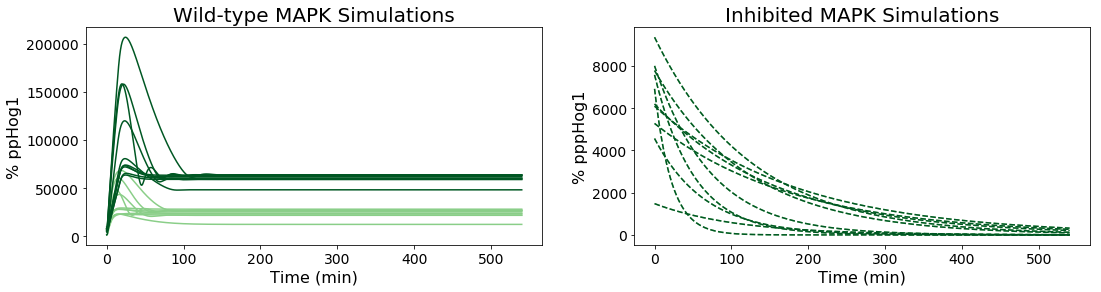

In [222]:
# X species
plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, map2k_doses, time, 3)

In [223]:
# plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, map2k_doses, time, 4)

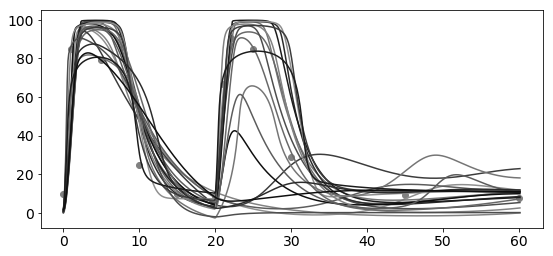

In [224]:
# step
plt_ramp_behaviors(top_params_a1_1D, plt_top, params_constants, initials, gen, time, 2, hog1_ramp_data, mapk_ramp_time)

In [ ]:
plt_mses_gen(gen,mse_a1_1D)

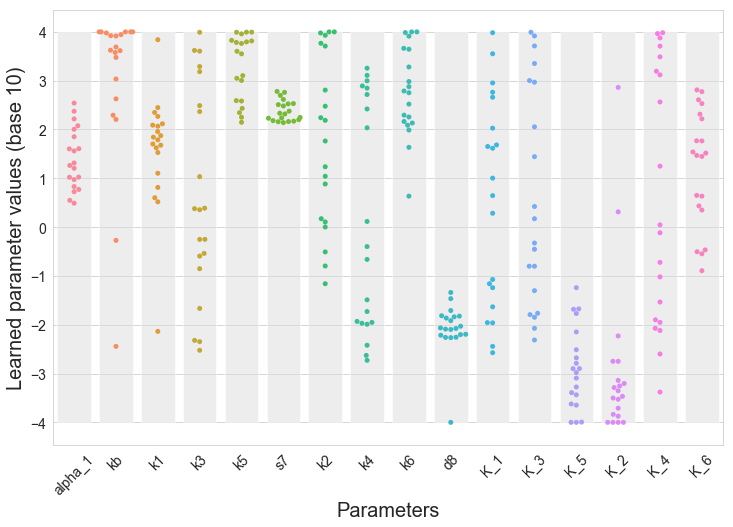

In [225]:
    # positive 3db7d6
    # negative ee9537
    # hog1 ? 38bf85 or 94ddaa

colors = ['#3c3c3c','#3c3c3c'] #+ rocket[::-1][:4] + rocket[::-1][:4]+ rocket[::-1][:3]+ rocket[::-1][:3]

plot_param_ranges(labelnames, diff, minimums, df_top_params_log_M)

##  190705_ptp_ptc.py -  two mutual inhibitions steps, no negative feedback

**Notes** 


### Inputs

In [150]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/from/fit_to_ramp/190705_ptp_ptc/'
gen = 1000
runs = 2000

MAP3K = 0
MAP2K = 0
MAPK = 0
PTC = molarity_conversion(400)
PTP = molarity_conversion(118)

MAP3K_t = molarity_conversion(701)
MAP2K_t = molarity_conversion(2282)
MAPK_t = molarity_conversion(5984)
PTC_t = molarity_conversion(400)
PTP_t = molarity_conversion(118)

# s = [0, 50000, 150000, 250000, 350000, 450000, 550000]


labelnames = [    'alpha_1', 'alpha_2', 'alpha_3', 'alpha_4', 'kb', 'k1', 'k3', 'k5', 'k7', 'k9', 'k2', 'k4', 'k6', 'K_1', 'K_3', 'K_5', 'K_7', 'K_9', 'K_2', 'K_4', 'K_6', 'K_8', 'K_10' #23
                ]

minimums = [-4, -4, -4, -4,
    -4, -4, -4, -4, -4, -4,
    -4, -4, -4,
    -4, -4, -4, -4, -4,
    -4, -4, -4, -4, -4]

maximums = [ 4, 8, 4, 4,
    4, 4, 4, 4, 4, 4,
    4, 4, 4,
    4, 4, 4, 4, 4,
    4, 4, 4, 4, 4]

diff = np.asarray(maximums)-np.asarray(minimums)

# fb = 1
# t100a_fb = 0

initials = [MAP3K, MAP2K, MAPK, PTC, PTP]
# params_constants = [MAP3K_t, MAP2K_t, MAPK_t, PTP_t] 
params_constants = [MAP3K_t, MAP2K_t, MAPK_t, PTC_t, PTP_t] 
doses = [0, 50000, 150000, 250000, 350000, 450000, 550000]
map2k_doses = [150000, 550000]
mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

labels = ['MAP3K','MAP2K','MAPK','gly','PTP']

In [151]:
if len(labelnames) == len(diff):
    print('Params and labels match')

Params and labels match


In [164]:
def ptp_ptc(initials,t,total_protein,sig,params):
    MAP3K, MAP2K, MAPK, PTC, PTP = initials
    MAP3K_t, MAP2K_t, MAPK_t, PTC_t, PTP_t = total_protein
    alpha_1, alpha_2, alpha_3, alpha_4, kb, k1, k3, k5, k7, k9, k2, k4, k6, K_1, K_3, K_5, K_7, K_9, K_2, K_4, K_6, K_8, K_10 = params #23

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    PTC_I = PTC_t-PTC
    PTP_I = PTP_t-PTP

    # dMAP3K = (((sig*k1+kb)/(1+gly/beta_3))*MAP3K_I)/(K_1+MAP3K_I) - ((k2)*MAP3K/(K_2+MAP3K))
    dMAP3K = ((sig*k1+kb)*MAP3K_I)/(K_1+MAP3K_I) - ((k2)*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - ((k6+alpha_2*PTP+alpha_4*PTC)*MAPK)/(K_6+MAPK)
    # dgly = s7*MAPK - d8*gly
    dPTC = (k7*PTC_I/(K_7+PTC_I)) - ((alpha_3*MAPK)*PTC)/(K_8+PTC)
    dPTP = (k9*PTP_I/(K_9+PTP_I)) - ((alpha_1*MAPK)*PTP)/(K_10+PTP)


    return dMAP3K, dMAP2K, dMAPK, dPTC, dPTP

def run_wt_ss(inits, total_protein, learned_params):
    ss = fsolve(ptp_ptc, inits, args=(0,total_protein, 0, learned_params))
    return ss

def simulate_wt_experiment(inits, total_protein, sig, learned_params, time):
    odes = odeint(ptp_ptc, inits, time, args=(total_protein, sig, learned_params))
    return odes

def simulate_t100a_experiment(inits, total_protein, sig, learned_params, time):
    alpha_1, alpha_2, alpha_3, alpha_4, kb, k1, k3, k5, k7, k9, k2, k4, k6, K_1, K_3, K_5, K_7, K_9, K_2, K_4, K_6, K_8, K_10 = learned_params #23
    learned_params = 0, alpha_2, 0, alpha_4, kb, k1, k3, k5, k7, k9, k2, k4, k6, K_1, K_3, K_5, K_7, K_9, K_2, K_4, K_6, K_8, K_10 #23

    #solve odes:
    odes = odeint(ptp_ptc, inits, time, args=(total_protein, sig, learned_params))
    return odes


def b3_b2_a1_1D_ramp(initials,t,total_protein,params):
    MAP3K, MAP2K, MAPK, PTC, PTP = initials
    MAP3K_t, MAP2K_t, MAPK_t, PTC_t, PTP_t = total_protein
    alpha_1, alpha_2, alpha_3, alpha_4, kb, k1, k3, k5, k7, k9, k2, k4, k6, K_1, K_3, K_5, K_7, K_9, K_2, K_4, K_6, K_8, K_10 = params #23

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    PTC_I = PTC_t-PTC
    PTP_I = PTP_t-PTP
    
    sig = signal_ramp_special(t)
    
    # dMAP3K = (((sig*k1+kb)/(1+gly/beta_3))*MAP3K_I)/(K_1+MAP3K_I) - ((k2)*MAP3K/(K_2+MAP3K))
    dMAP3K = ((sig*k1+kb)*MAP3K_I)/(K_1+MAP3K_I) - ((k2)*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - ((k6+alpha_2*PTP+alpha_4*PTC)*MAPK)/(K_6+MAPK)
    # dgly = s7*MAPK - d8*gly
    dPTC = (k7*PTC_I/(K_7+PTC_I)) - ((alpha_3*MAPK)*PTC)/(K_8+PTC)
    dPTP = (k9*PTP_I/(K_9+PTP_I)) - ((alpha_1*MAPK)*PTP)/(K_10+PTP)

    return dMAP3K, dMAP2K, dMAPK, dPTC, dPTP

def simulate_ramp_experiment(inits, total_protein, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params

    #solve odes:
    odes = odeint(b3_b2_a1_1D_ramp, inits, time, args=(total_protein, learned_params))
    return odes


def signal_ramp_special(t_step):
    sig = 0
    if t_step >= .001:
        sig = 250000
    if t_step >= 20:
        sig = 550000
    return sig

In [154]:
def run_ss(inits, total_protein, learned_params):
    ss = fsolve(ptp_ptc, inits, args=(0,total_protein, 0, learned_params))#/total_protein*100
    return ss

# def run_t100a_ss(inits, total_protein, learned_params):
#     beta_3, alpha_1, alpha_2, kb, k1, k3, k5, s7, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10 = learned_params #21
#     learned_params = beta_3, 0, alpha_2, kb, k1, k3, k5, 0, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10
#     ss = fsolve(b3_a1_1D, inits, args=(0,total_protein, 0, learned_params))
#     return ss

### Gather simulated data

In [155]:
idx_top, top_params_a1_1D, top, plt_top, new_params, params_from_file, mse_a1_1D, last_mses_a1_1D = gather_simulated_data(folder, gen, runs, 0.01)
df_top_params = pd.DataFrame(top_params_a1_1D)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M = df_top_params_log.melt(var_name='param', value_name='vals')

Best MSE: 9470.27893876658
Mean MSE of top 5%: 11316.312230995027


### Plot

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


<Figure size 864x576 with 0 Axes>

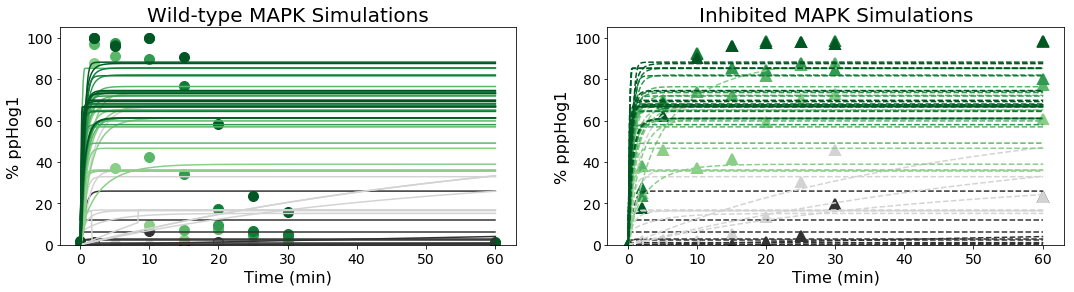

In [157]:
plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time)
# plt.savefig("C:/Users/sksuzuki/Documents/Research/figures/simulations/hog1.png",dpi=150,bbox_inches='tight')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 864x576 with 0 Axes>

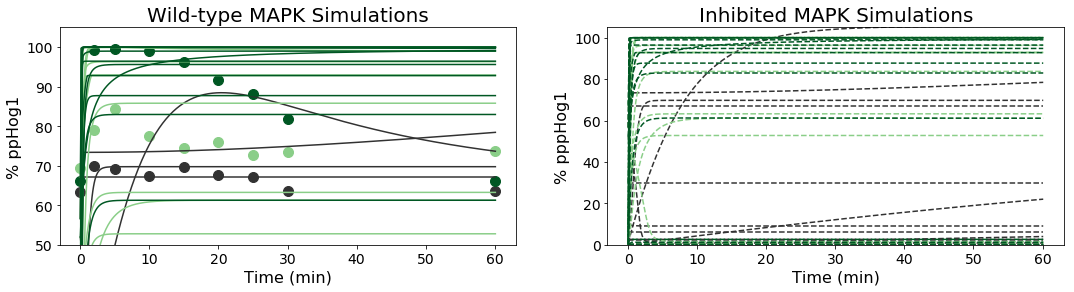

In [158]:
plt_param_behaviors(top_params_a1_1D, 20, [MAP3K_t, MAP2K_t, MAPK_t, 1, 0], initials, 5000, [0]+map2k_doses, time, 2, mapk_ptp_data, None, mapk_time)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


<Figure size 864x576 with 0 Axes>

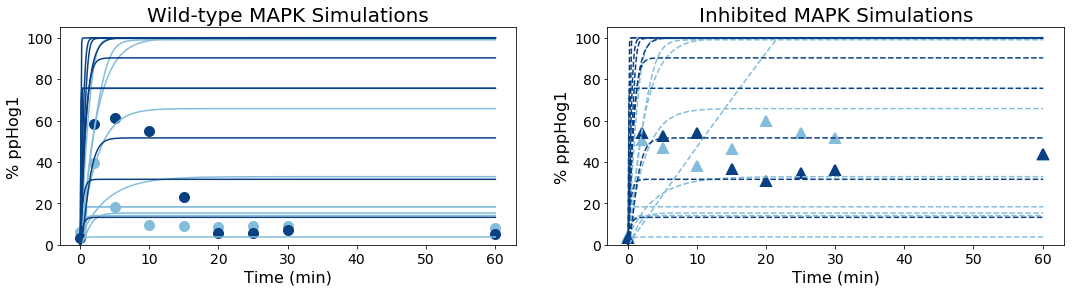

In [159]:
plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, map2k_doses, time, 1, map2k_wt_data, map2k_t100a_data, mapk_time)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


<Figure size 864x576 with 0 Axes>

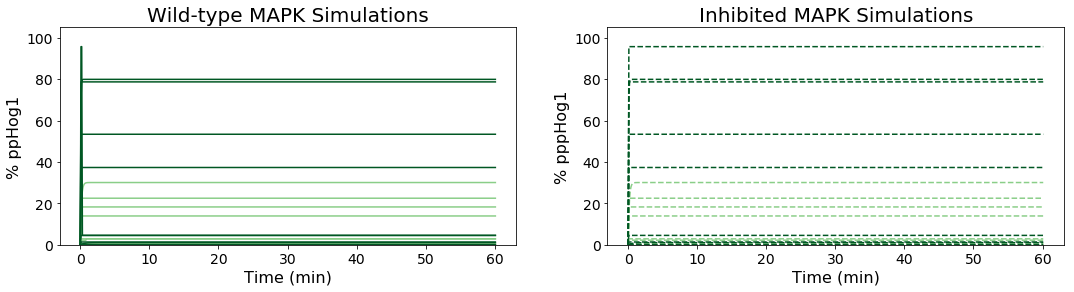

In [160]:
plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, map2k_doses, time, 0)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


<Figure size 864x576 with 0 Axes>

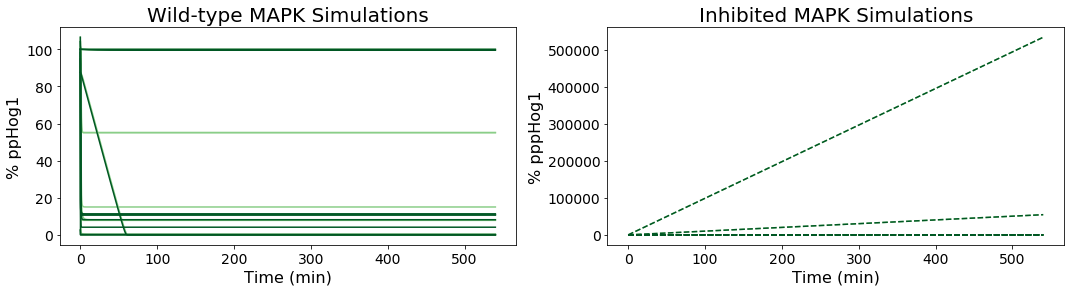

In [161]:
plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, map2k_doses, time, 3)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


<Figure size 864x576 with 0 Axes>

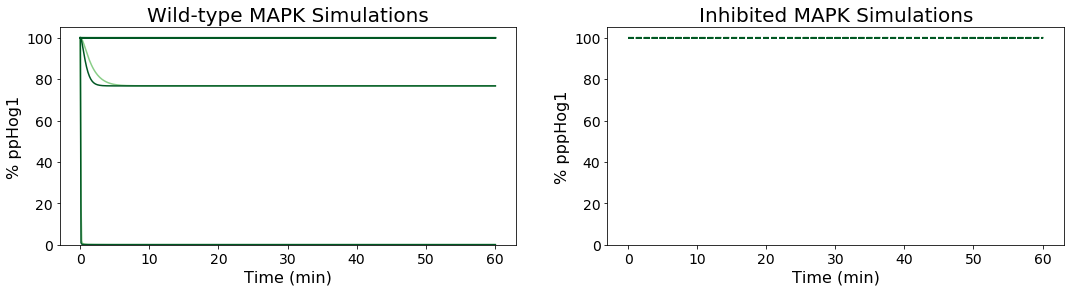

In [162]:
plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, map2k_doses, time, 4)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


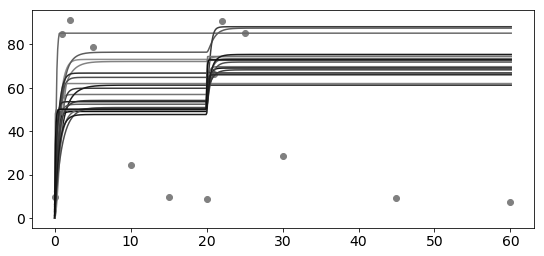

In [165]:
plt_ramp_behaviors(top_params_a1_1D, plt_top, params_constants, initials, gen, time, 2, hog1_ramp_data, mapk_ramp_time)

<Figure size 864x576 with 0 Axes>

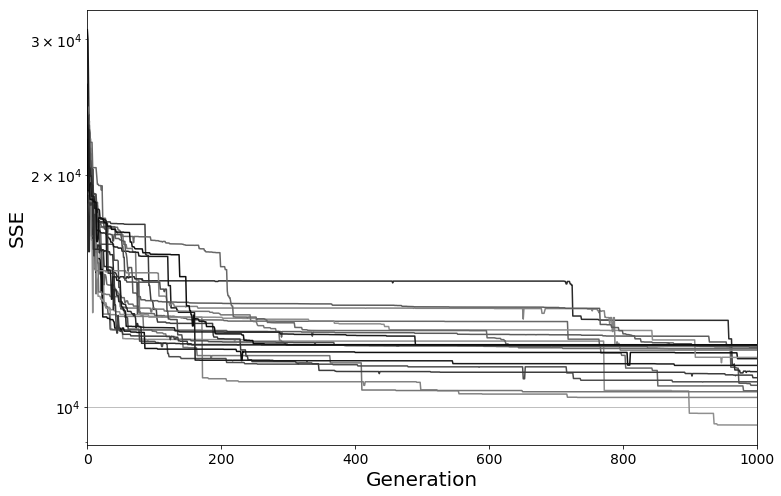

In [166]:
plt_mses_gen(gen,mse_a1_1D)

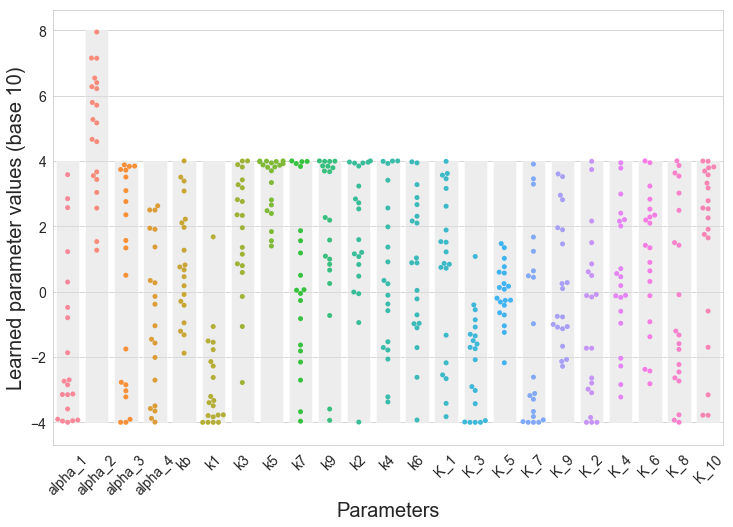

In [167]:
    # positive 3db7d6
    # negative ee9537
    # hog1 ? 38bf85 or 94ddaa

colors = ['#3c3c3c','#3c3c3c'] #+ rocket[::-1][:4] + rocket[::-1][:4]+ rocket[::-1][:3]+ rocket[::-1][:3]

plot_param_ranges(labelnames, diff, minimums, df_top_params_log_M)

##  190705_WT_ptp.py -  fit to just wt and ptp23D

**Notes** 


### Inputs

In [176]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/from/fit_to_ramp/190705_WT_ptp23D/'
gen = 1000
runs = 2000

MAP3K = 0
MAP2K = 0
MAPK = 0
X = 0
PTP = molarity_conversion(118)

MAP3K_t = molarity_conversion(701)
MAP2K_t = molarity_conversion(2282)
MAPK_t = molarity_conversion(5984)
PTP_t = molarity_conversion(118)

# s = [0, 50000, 150000, 250000, 350000, 450000, 550000]


labelnames = ['beta_3', 'alpha_1', 'alpha_2', 'kb', 'k1', 'k3', 'k5', 's7', 'k9', 'k2', 'k4', 'k6', 'd8', 'K_1', 'K_3', 'K_5', 'K_9', 'K_2', 'K_4', 'K_6', 'K_10'
                ]

minimums = [-4, -4, -4,
    -4, -4, -4, -4, -4,
    -4, -4, -4, -4, -4,
    -4, -4, -4, -4,
    -4, -4, -4, -4]

maximums = [ 4, 4, 8,
    4, 4, 4, 4, 4,
    4, 4, 4, 4, 4,
    4, 4, 4, 4,
    4, 4, 4, 4]

diff = np.asarray(maximums)-np.asarray(minimums)

# fb = 1
# t100a_fb = 0

initials = [MAP3K, MAP2K, MAPK, X, PTP]
# params_constants = [MAP3K_t, MAP2K_t, MAPK_t, PTP_t] 
params_constants = [MAP3K_t, MAP2K_t, MAPK_t, 1, PTP_t] 
doses = [0, 50000, 150000, 250000, 350000, 450000, 550000]
map2k_doses = [150000, 550000]
mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

labels = ['MAP3K','MAP2K','MAPK','gly','PTP']

In [169]:
if len(labelnames) == len(diff):
    print('Params and labels match')

Params and labels match


In [174]:
def b3_a1_1D(initials,t,total_protein,sig,params):
    MAP3K, MAP2K, MAPK, gly, PTP = initials
    MAP3K_t, MAP2K_t, MAPK_t, _, PTP_t = total_protein
    beta_3, alpha_1, alpha_2, kb, k1, k3, k5, s7, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10 = params #21

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    PTP_I = PTP_t-PTP

    dMAP3K = (((sig*k1+kb)/(1+gly/beta_3))*MAP3K_I)/(K_1+MAP3K_I) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - ((k6+alpha_2*PTP)*MAPK)/(K_6+MAPK)
    dgly = s7*MAPK - d8*gly
    dPTP = (k9*PTP_I/(K_9+PTP_I)) - ((alpha_1*MAPK)*PTP)/(K_10+PTP)

    return dMAP3K, dMAP2K, dMAPK, dgly, dPTP

def run_wt_ss(inits, total_protein, learned_params):
    ss = fsolve(b3_a1_1D, inits, args=(0,total_protein, 0, learned_params))
    return ss

def simulate_wt_experiment(inits, total_protein, sig, learned_params, time):
    odes = odeint(b3_a1_1D, inits, time, args=(total_protein, sig, learned_params))
    return odes

def b3_a1_1D_ramp(initials,t,total_protein,params):
    MAP3K, MAP2K, MAPK, gly, PTP = initials
    MAP3K_t, MAP2K_t, MAPK_t, _, PTP_t = total_protein
    beta_3, alpha_1, alpha_2, kb, k1, k3, k5, s7, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10 = params #21

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    PTP_I = PTP_t-PTP

    sig = signal_ramp_special(t)

    dMAP3K = (((sig*k1+kb)/(1+gly/beta_3))*MAP3K_I)/(K_1+MAP3K_I) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - ((k6+alpha_2*PTP)*MAPK)/(K_6+MAPK)
    dgly = s7*MAPK - d8*gly
    dPTP = (k9*PTP_I/(K_9+PTP_I)) - ((alpha_1*MAPK)*PTP)/(K_10+PTP)

    return dMAP3K, dMAP2K, dMAPK, dgly, dPTP

    dMAP3K = (((sig*k1+kb)/(1+gly/beta_3))*MAP3K_I)/(K_1+MAP3K_I) - ((k2+beta_2*MAPK)*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - ((k6+alpha_2*PTP)*MAPK)/(K_6+MAPK)
    dgly = s7*MAPK - d8*gly
    dPTP = (k9*PTP_I/(K_9+PTP_I)) - ((alpha_1*MAPK)*PTP)/(K_10+PTP)

    return dMAP3K, dMAP2K, dMAPK, dgly, dPTP


def simulate_t100a_experiment(inits, total_protein, sig, learned_params, time):
    beta_3, alpha_1, alpha_2, kb, k1, k3, k5, s7, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10 = learned_params #21
    learned_params = beta_3, 0, alpha_2, kb, k1, k3, k5, 0, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10
    #solve odes:
    odes = odeint(b3_a1_1D, inits, time, args=(total_protein, sig, learned_params))
    return odes

def simulate_ramp_experiment(inits, total_protein, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params

    #solve odes:
    odes = odeint(b3_a1_1D_ramp, inits, time, args=(total_protein, learned_params))
    return odes

def signal_ramp_special(t_step):
    sig = 0
    if t_step >= .001:
        sig = 250000
    if t_step >= 20:
        sig = 550000
    return sig

In [171]:
def run_ss(inits, total_protein, learned_params):
    ss = fsolve(b3_a1_1D, inits, args=(0,total_protein, 0, learned_params))#/total_protein*100
    return ss

### Gather simulated data

In [177]:
idx_top, top_params_a1_1D, top, plt_top, new_params, params_from_file, mse_a1_1D, last_mses_a1_1D = gather_simulated_data(folder, gen, runs, 0.01)
df_top_params = pd.DataFrame(top_params_a1_1D)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M = df_top_params_log.melt(var_name='param', value_name='vals')

Best MSE: 496.33967674579895
Mean MSE of top 5%: 578.5226923142963


### Plot

<Figure size 864x576 with 0 Axes>

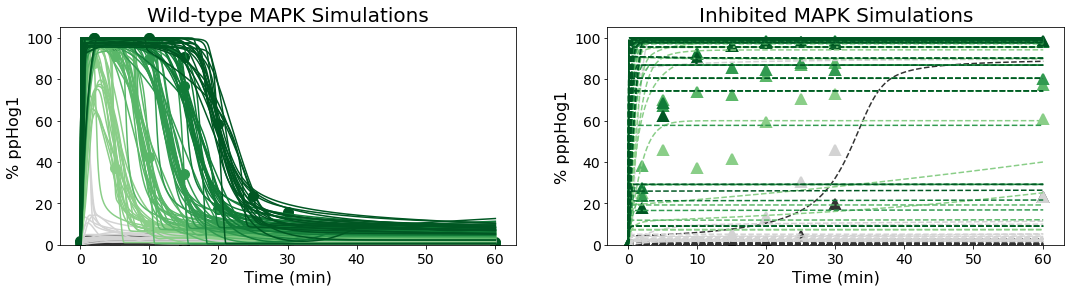

In [178]:
plt_param_behaviors(top_params_a1_1D, 20, params_constants, initials, 5000, doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time)
# plt.savefig("C:/Users/sksuzuki/Documents/Research/figures/simulations/hog1.png",dpi=150,bbox_inches='tight')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1200.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


<Figure size 864x576 with 0 Axes>

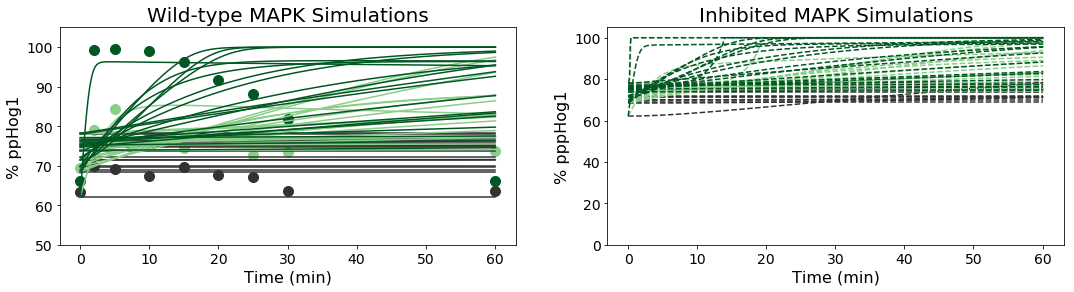

In [179]:
plt_param_behaviors(top_params_a1_1D, 20, [MAP3K_t, MAP2K_t, MAPK_t, 1, 0], initials, 5000, [0]+map2k_doses, time, 2, mapk_ptp_data, None, mapk_time)

<Figure size 864x576 with 0 Axes>

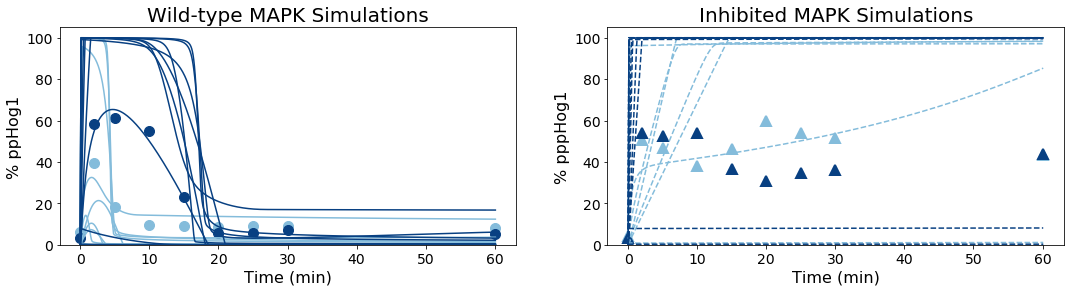

In [180]:
plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, map2k_doses, time, 1, map2k_wt_data, map2k_t100a_data, mapk_time)

<Figure size 864x576 with 0 Axes>

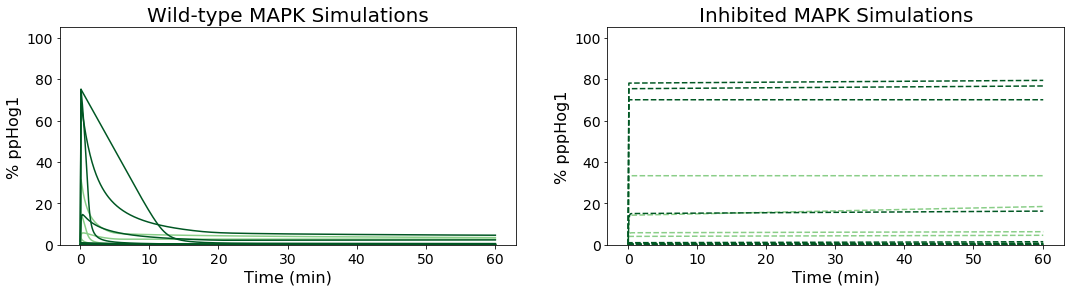

In [181]:
plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, map2k_doses, time, 0)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1200.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

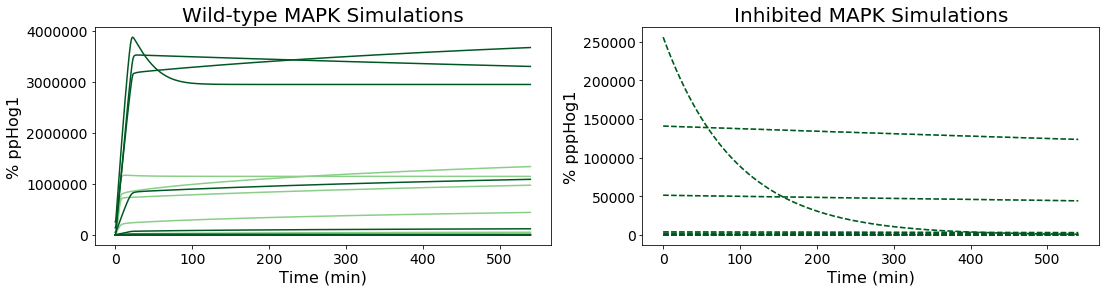

In [30]:
plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, map2k_doses, time, 3)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1200.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

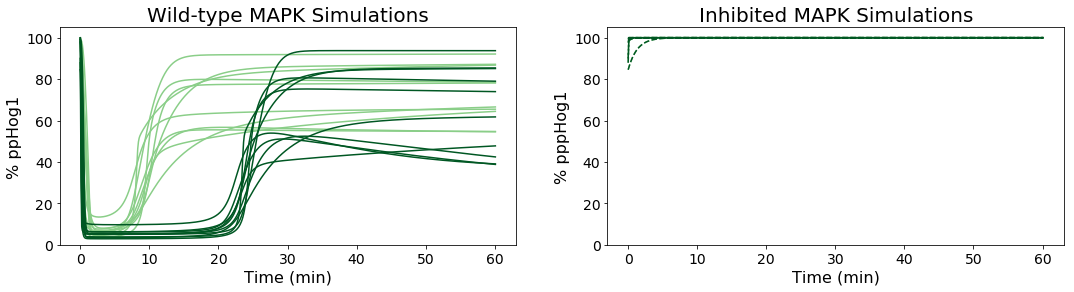

In [31]:
plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, map2k_doses, time, 4)

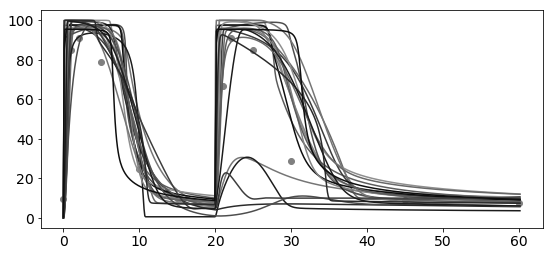

In [182]:
plt_ramp_behaviors(top_params_a1_1D, plt_top, params_constants, initials, gen, time, 2, hog1_ramp_data, mapk_ramp_time)

<Figure size 864x576 with 0 Axes>

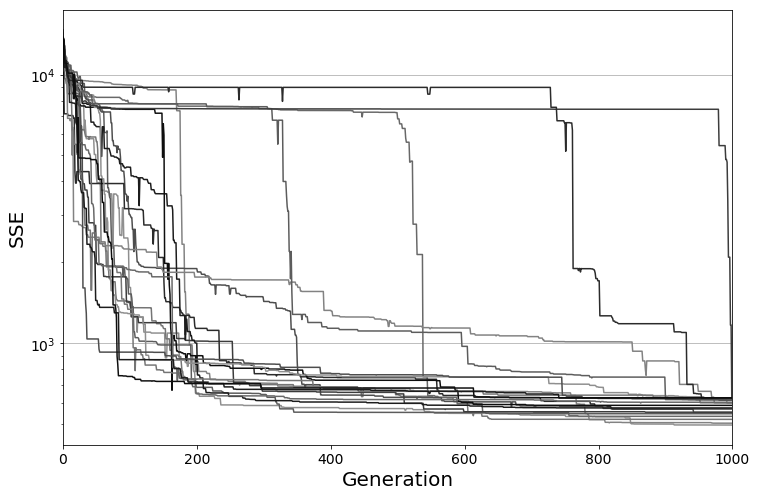

In [183]:
plt_mses_gen(gen,mse_a1_1D)

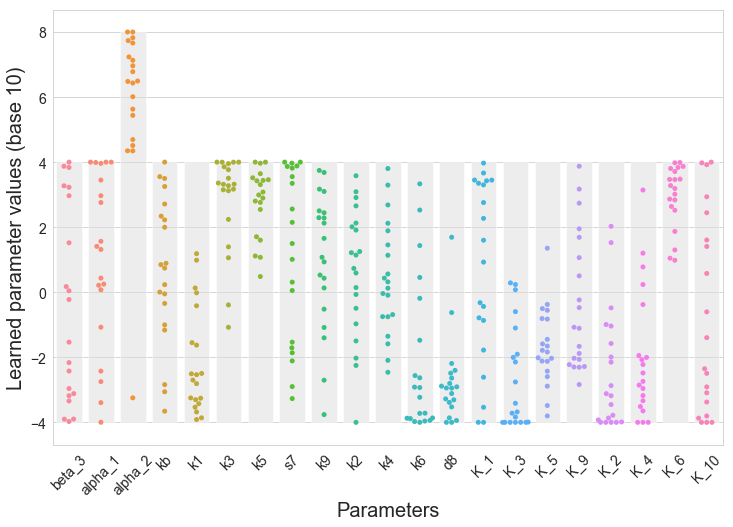

In [184]:
    # positive 3db7d6
    # negative ee9537
    # hog1 ? 38bf85 or 94ddaa

colors = ['#3c3c3c','#3c3c3c'] #+ rocket[::-1][:4] + rocket[::-1][:4]+ rocket[::-1][:3]+ rocket[::-1][:3]

plot_param_ranges(labelnames, diff, minimums, df_top_params_log_M)

# Predictions

## Change Signal



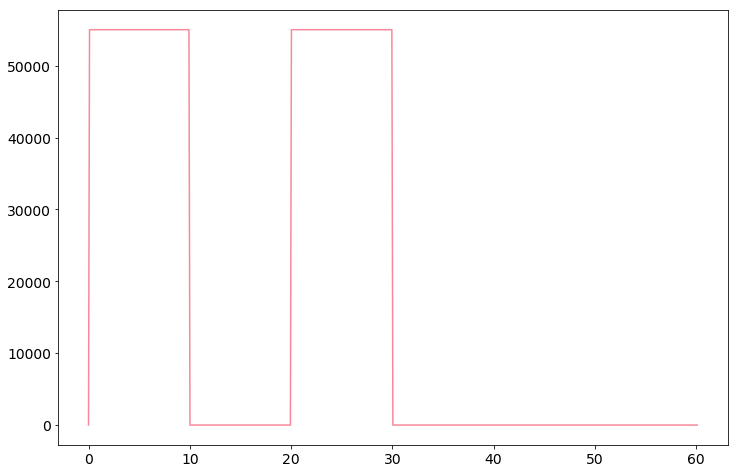

In [345]:
def signal_periodic(t_step, signal, period):
    if t_step == 0:
        s = 0
    elif t_step >= 60:
        s = 0
    elif t_step >= 30:
        s = 0
    elif np.floor(t_step / period) % 2 == 0:
        s =  signal
    else:
        s = 0
#     signal = 
#     print(len_period)
    return s
# [signal_periodic(x, 55000, 20) for x in time]

plt.plot(time, [signal_periodic(x, 55000, 10) for x in time])

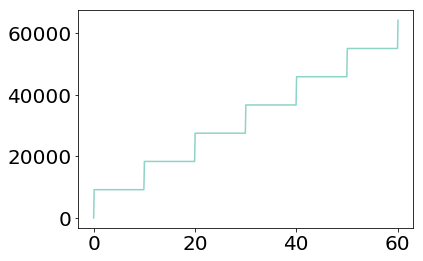

In [115]:
def signal_ramp(t_step, signal_end, step_len):
    num_steps = 60 / step_len
    cut_off = np.ceil(t_step/step_len)
    step = signal_end/num_steps
    return step*cut_off
plt.plot(time,[signal_ramp(x, 55000, 10) for x in time])

## Functions

In [113]:
def b3_aN_1D_predict(initals,t,params_constants,params, signal_fxn, fxn_params):
    MAP3K, MAP2K, MAPK, X = initals
    MAP3K_t, MAP2K_t, MAPK_t = params_constants
    beta_3, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6 = params
    
    s = signal_fxn(t,fxn_params[1],fxn_params[2])

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK

    dMAP3K = (s/(1+X/beta_3)) * (((k1)*MAP3K_I)/(K_1+MAP3K_I)) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - (k6*MAPK/(K_6+MAPK))
    dX = s7*MAPK - d8*X

    return dMAP3K, dMAP2K, dMAPK, dX

def b3_a1_1D_predict(initals,t,params_constants,params, signal_fxn, fxn_params):
    MAP3K, MAP2K, MAPK, X = initals
    MAP3K_t, MAP2K_t, MAPK_t = params_constants
    beta_3, alpha_1, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6 = params
    
    s = signal_fxn(t,fxn_params[1],fxn_params[2])

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK

    dMAP3K = (s/(1+X/beta_3)) * (((k1)*MAP3K_I)/(K_1+MAP3K_I)) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K+alpha_1*MAPK)*MAPK_I)/(K_5+MAPK_I)) - (k6*MAPK/(K_6+MAPK))
    dX = s7*MAPK - d8*X

    return dMAP3K, dMAP2K, dMAPK, dX

def b3_a2_1D_predict(initals,t,params_constants,params, signal_fxn, fxn_params):
    MAP3K, MAP2K, MAPK, X = initals
    MAP3K_t, MAP2K_t, MAPK_t = params_constants
    beta_3, alpha_2, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6 = params
    
    s = signal_fxn(t,fxn_params[1],fxn_params[2])

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK

    dMAP3K = (s/(1+X/beta_3)) * (((k1)*MAP3K_I)/(K_1+MAP3K_I)) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K+alpha_2*MAPK)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - (k6*MAPK/(K_6+MAPK))
    dX = s7*MAPK - d8*X

    return dMAP3K, dMAP2K, dMAPK, dX

def b3_a3_1D_predict(initals,t,params_constants,params, signal_fxn, fxn_params):
    MAP3K, MAP2K, MAPK, X = initals
    MAP3K_t, MAP2K_t, MAPK_t = params_constants
    beta_3, alpha_3, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6 = params
    
    s = signal_fxn(t,fxn_params[1],fxn_params[2])

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK

    dMAP3K = (s/(1+X/beta_3)) * (((k1+alpha_3*MAPK)*MAP3K_I)/(K_1+MAP3K_I)) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - (k6*MAPK/(K_6+MAPK))
    dX = (s7*MAPK) - (d8*X)

    return dMAP3K, dMAP2K, dMAPK, dX

<Figure size 432x288 with 0 Axes>

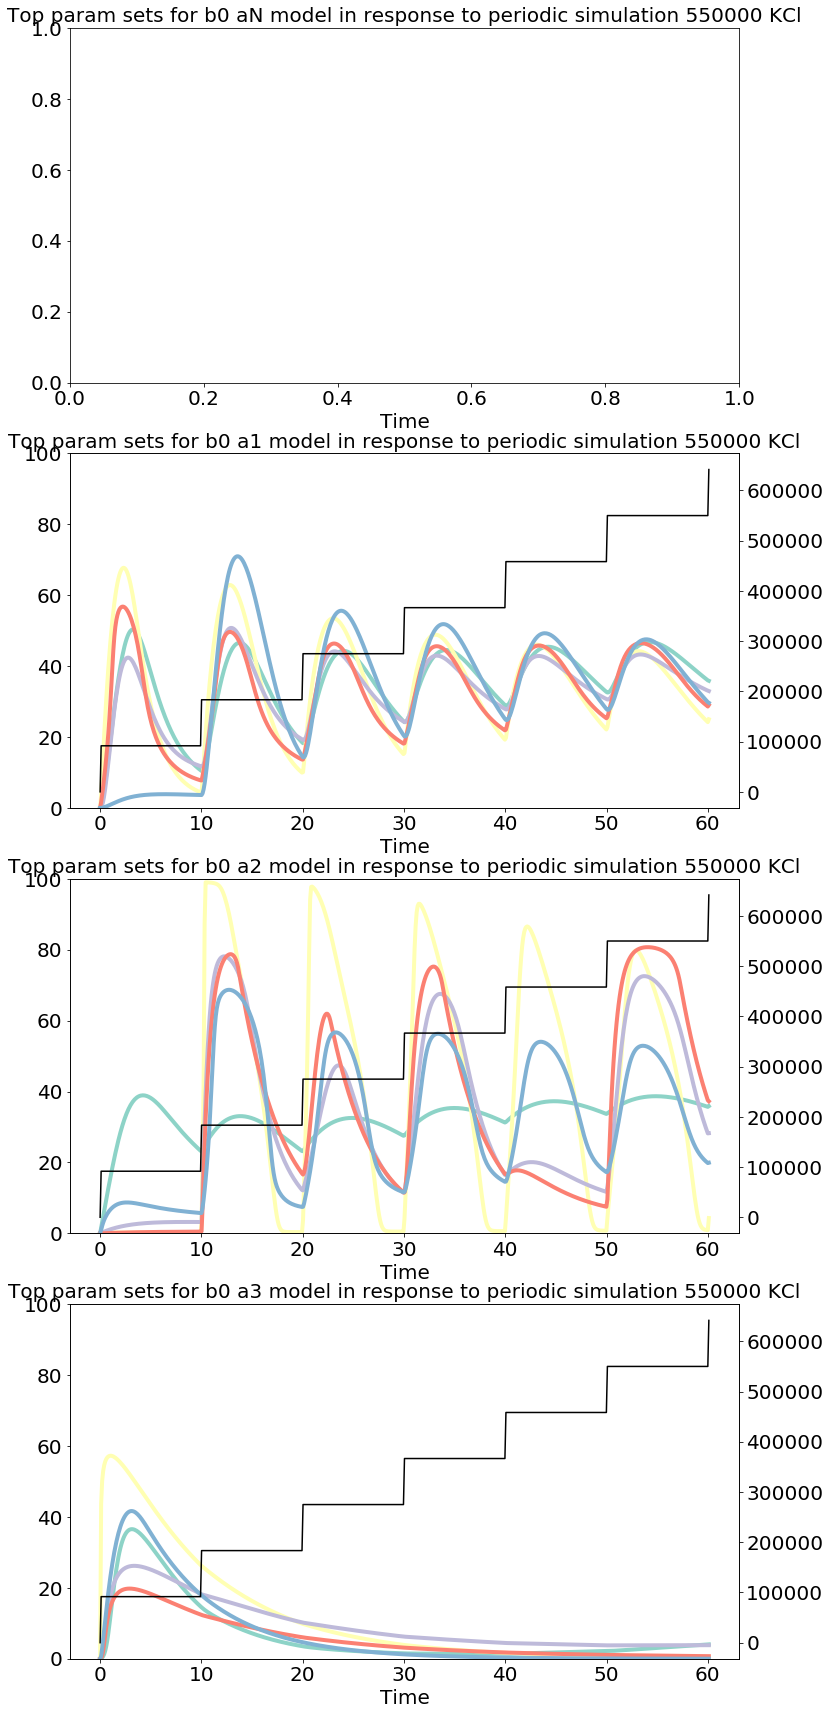

In [140]:
len_step_min = 10
signal = 550000
num_predict = 5

#initialize figure:
plt.clf()
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, 1, figsize=(12,30))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)

initals = [MAP3K, MAP2K, MAPK, X]
params_constants = [MAP3K_t, MAP2K_t, MAPK_t]

colors = sns.color_palette("Set3", 20)
sns.set_palette(colors)

#plot 1
title_text = 'Top param sets for b0 aN model in response to periodic simulation '+str(signal)+' KCl'
ax1.set_title(title_text, fontsize=20)
ax1.set_xlabel('Time', fontsize=20)

# for idx, param_set in enumerate(top_params_aN_1D[:num_predict]):
#     data = odeint(b3_aN_1D_predict, initals, time, args=(params_constants, param_set,signal_ramp,[_, signal, len_step_min]))
#     ax1.plot(time,data[:,2]/params_constants[2]*100,label=str(idx),linewidth=4)
    
# ax1.set_ylim(0,100)
# ax1b = ax1.twinx()
# ax1b.plot(time,[signal_ramp(x, signal, len_step_min) for x in time], color='black')
# ax1.legend()
    
    
#plot2
title_text = 'Top param sets for b0 a1 model in response to periodic simulation '+str(signal)+' KCl'
ax2.set_title(title_text, fontsize=20)
ax2.set_xlabel('Time', fontsize=20)

for idx, param_set in enumerate(top_params_a1_1D[:num_predict]):
    data = odeint(b3_a1_1D_predict, initals, time, args=(params_constants, param_set,signal_ramp,[_, signal, len_step_min]))
    ax2.plot(time,data[:,2]/params_constants[2]*100,label=str(idx),linewidth=4)
    
ax2.set_ylim(0,100)
ax2b = ax2.twinx()
ax2b.plot(time,[signal_ramp(x, signal, len_step_min) for x in time], color='black')
# ax2.legend()


#plot 3
title_text = 'Top param sets for b0 a2 model in response to periodic simulation '+str(signal)+' KCl'
ax3.set_title(title_text, fontsize=20)
ax3.set_xlabel('Time', fontsize=20)


for idx, param_set in enumerate(top_params_a2_1D[:num_predict]):
    data = odeint(b3_a2_1D_predict, initals, time, args=(params_constants, param_set,signal_ramp,[_, signal, len_step_min]))
    ax3.plot(time,data[:,2]/params_constants[2]*100,label=str(idx),linewidth=4)
    
ax3.set_ylim(0,100)
ax3b = ax3.twinx()
ax3b.plot(time,[signal_ramp(x, signal, len_step_min) for x in time], color='black')

#plot 4
title_text = 'Top param sets for b0 a3 model in response to periodic simulation '+str(signal)+' KCl'
ax4.set_title(title_text, fontsize=20)
ax4.set_xlabel('Time', fontsize=20)

# initals = [MAP3K, MAP2K, MAPK, X, Y]
# params_constants = [MAP3K_t, MAP2K_t, MAPK_t, X_t, Y_t]

for idx, param_set in enumerate(top_params_a3_1D[:num_predict]):
    data = odeint(b3_a3_1D_predict, initals, time, args=(params_constants, param_set,signal_ramp,[_, signal, len_step_min]))
    ax4.plot(time,data[:,2]/params_constants[2]*100,label=str(idx),linewidth=4)
    
ax4.set_ylim(0,100)
ax4b = ax4.twinx()
ax4b.plot(time,[signal_ramp(x, signal, len_step_min) for x in time], color='black')

# ax3.legend()
plt.show()

In [147]:
def signal_ramp_special(t_step):
    sig = 0
    if t_step >= .001:
        sig = 250000
    if t_step >= 15:
        sig = 550000
    return sig
def b3_aN_1D_predict(initals,t,params_constants,params, signal_fxn, fxn_params=None):
    MAP3K, MAP2K, MAPK, X = initals
    MAP3K_t, MAP2K_t, MAPK_t = params_constants
    beta_3, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6 = params
    
    if fxn_params:
        s = signal_fxn(t,fxn_params[1],fxn_params[2])
    else:
        s = signal_fxn(t)
        
    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK

    dMAP3K = (s/(1+X/beta_3)) * (((k1)*MAP3K_I)/(K_1+MAP3K_I)) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - (k6*MAPK/(K_6+MAPK))
    dX = s7*MAPK - d8*X

    return dMAP3K, dMAP2K, dMAPK, dX

def b3_a1_1D_predict(initals,t,params_constants,params, signal_fxn, fxn_params=None):
    MAP3K, MAP2K, MAPK, X = initals
    MAP3K_t, MAP2K_t, MAPK_t = params_constants
    beta_3, alpha_1, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6 = params
    
    if fxn_params:
        s = signal_fxn(t,fxn_params[1],fxn_params[2])
    else:
        s = signal_fxn(t)

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK

    dMAP3K = (s/(1+X/beta_3)) * (((k1)*MAP3K_I)/(K_1+MAP3K_I)) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K+alpha_1*MAPK)*MAPK_I)/(K_5+MAPK_I)) - (k6*MAPK/(K_6+MAPK))
    dX = s7*MAPK - d8*X

    return dMAP3K, dMAP2K, dMAPK, dX

def b3_a2_1D_predict(initals,t,params_constants,params, signal_fxn, fxn_params=None):
    MAP3K, MAP2K, MAPK, X = initals
    MAP3K_t, MAP2K_t, MAPK_t = params_constants
    beta_3, alpha_2, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6 = params
    
    if fxn_params:
        s = signal_fxn(t,fxn_params[1],fxn_params[2])
    else:
        s = signal_fxn(t)

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK

    dMAP3K = (s/(1+X/beta_3)) * (((k1)*MAP3K_I)/(K_1+MAP3K_I)) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K+alpha_2*MAPK)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - (k6*MAPK/(K_6+MAPK))
    dX = s7*MAPK - d8*X

    return dMAP3K, dMAP2K, dMAPK, dX

def b3_a3_1D_predict(initals,t,params_constants,params, signal_fxn, fxn_params=None):
    MAP3K, MAP2K, MAPK, X = initals
    MAP3K_t, MAP2K_t, MAPK_t = params_constants
    beta_3, alpha_3, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6 = params
    
    if fxn_params:
        s = signal_fxn(t,fxn_params[1],fxn_params[2])
    else:
        s = signal_fxn(t)

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK

    dMAP3K = (s/(1+X/beta_3)) * (((k1+alpha_3*MAPK)*MAP3K_I)/(K_1+MAP3K_I)) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - (k6*MAPK/(K_6+MAPK))
    dX = (s7*MAPK) - (d8*X)

    return dMAP3K, dMAP2K, dMAPK, dX

<Figure size 432x288 with 0 Axes>

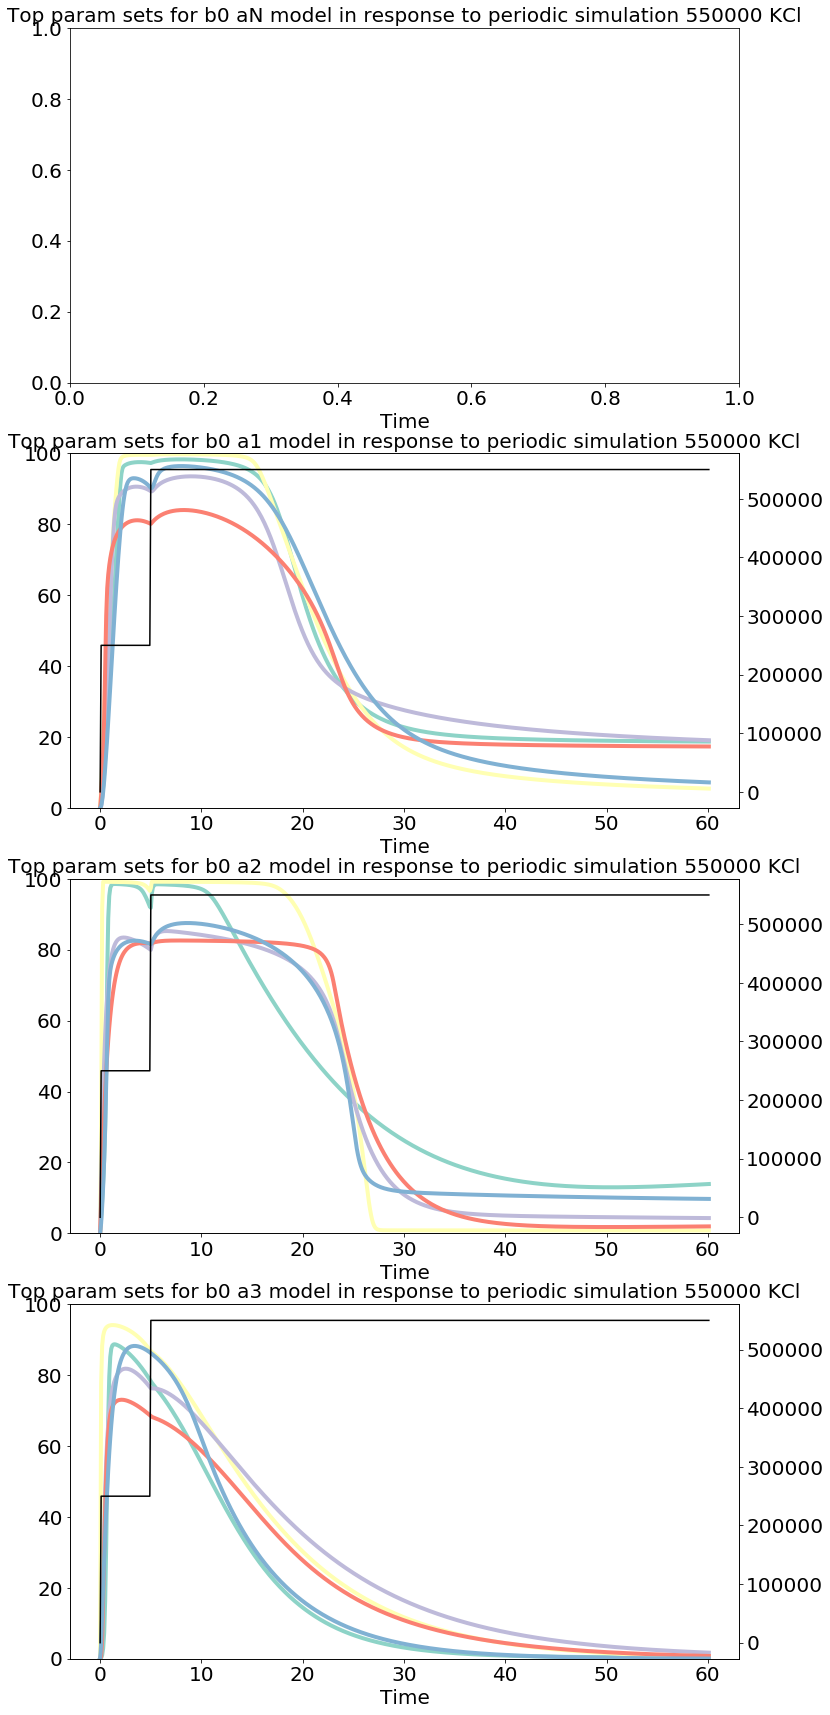

In [153]:


# len_step_min = 10
# signal = 550000
# num_predict = 10
def signal_ramp_special(t_step):
    sig = 0
    if t_step >= .001:
        sig = 250000
    if t_step >= 5:
        sig = 550000
    return sig
plt.plot(time,[signal_ramp_special(x) for x in time])


num_predict=5

#initialize figure:
plt.clf()
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, 1, figsize=(12,30))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)

initals = [MAP3K, MAP2K, MAPK, X]
params_constants = [MAP3K_t, MAP2K_t, MAPK_t]

colors = sns.color_palette("Set3", 20)
sns.set_palette(colors)

#plot 1
title_text = 'Top param sets for b0 aN model in response to periodic simulation '+str(signal)+' KCl'
ax1.set_title(title_text, fontsize=20)
ax1.set_xlabel('Time', fontsize=20)

# for idx, param_set in enumerate(top_params_aN_1D[:num_predict]):
#     data = odeint(b3_aN_1D_predict, initals, time, args=(params_constants, param_set,signal_ramp_special))
#     ax1.plot(time,data[:,2]/params_constants[2]*100,label=str(idx),linewidth=4)
    
# ax1.set_ylim(0,100)
# ax1b = ax1.twinx()
# ax1b.plot(time,[signal_ramp_special(x) for x in time], color='black')
# # ax1.legend()
    
    
#plot2
title_text = 'Top param sets for b0 a1 model in response to periodic simulation '+str(signal)+' KCl'
ax2.set_title(title_text, fontsize=20)
ax2.set_xlabel('Time', fontsize=20)

for idx, param_set in enumerate(top_params_a1_1D[:num_predict]):
    data = odeint(b3_a1_1D_predict, initals, time, args=(params_constants, param_set,signal_ramp_special))
    ax2.plot(time,data[:,2]/params_constants[2]*100,label=str(idx),linewidth=4)
    
ax2.set_ylim(0,100)
ax2b = ax2.twinx()
ax2b.plot(time,[signal_ramp_special(x) for x in time], color='black')
# ax2.legend()


#plot 3
title_text = 'Top param sets for b0 a2 model in response to periodic simulation '+str(signal)+' KCl'
ax3.set_title(title_text, fontsize=20)
ax3.set_xlabel('Time', fontsize=20)


for idx, param_set in enumerate(top_params_a2_1D[:num_predict]):#:num_predict]):
    data = odeint(b3_a2_1D_predict, initals, time, args=(params_constants, param_set,signal_ramp_special))
    ax3.plot(time,data[:,2]/params_constants[2]*100,label=str(idx),linewidth=4)
    
ax3.set_ylim(0,100)
ax3b = ax3.twinx()
ax3b.plot(time,[signal_ramp_special(x) for x in time], color='black')

#plot 4
title_text = 'Top param sets for b0 a3 model in response to periodic simulation '+str(signal)+' KCl'
ax4.set_title(title_text, fontsize=20)
ax4.set_xlabel('Time', fontsize=20)

# initals = [MAP3K, MAP2K, MAPK, X, Y]
# params_constants = [MAP3K_t, MAP2K_t, MAPK_t, X_t, Y_t]

for idx, param_set in enumerate(top_params_a3_1D[:num_predict]):
    data = odeint(b3_a3_1D_predict, initals, time, args=(params_constants, param_set,signal_ramp_special))
    ax4.plot(time,data[:,2]/params_constants[2]*100,label=str(idx),linewidth=4)
    
ax4.set_ylim(0,100)
ax4b = ax4.twinx()
ax4b.plot(time,[signal_ramp_special(x) for x in time], color='black')

# ax3.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

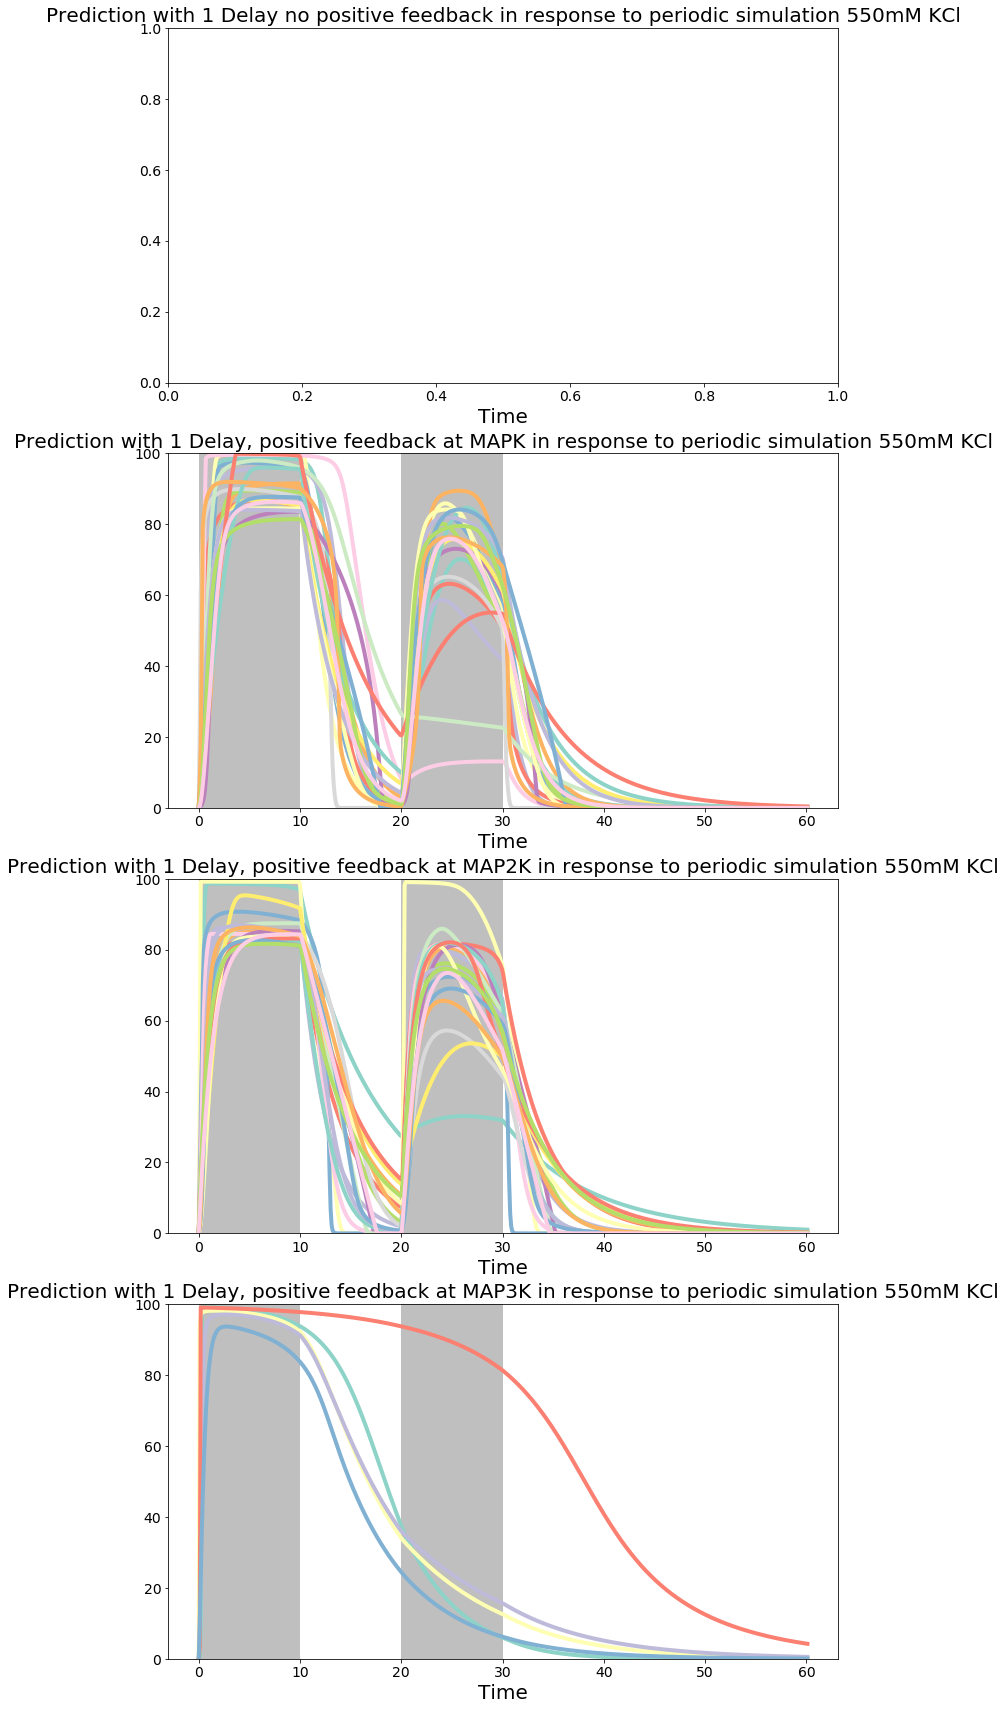

In [139]:
len_period_min = 10
signal = 550000
pulse_strain = 2

colors = sns.color_palette("Set3", 20)
sns.set_palette(colors)

#initialize figure:
plt.clf()
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, 1, figsize=(12,30))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)

initals = [MAP3K, MAP2K, MAPK, X]
params_constants = [MAP3K_t, MAP2K_t, MAPK_t]


#plot 1
title_text = 'Prediction with 1 Delay no positive feedback in response to periodic simulation 550mM KCl'
ax1.set_title(title_text, fontsize=20)
ax1.set_xlabel('Time', fontsize=20)

# for idx, param_set in enumerate(top_params_aN_1D[:20]):
#     data = odeint(b3_aN_1D_predict, initals, time, args=(params_constants, param_set,signal_periodic,[_, signal, len_period_min]))
#     ax1.plot(time,data[:,pulse_strain]/params_constants[pulse_strain]*100,label=str(idx),linewidth=4)
    
# ax1.set_ylim(0,100)
# for x in range(0,30,len_period_min*2):
#     ax1.fill_between([x,x+len_period_min], 0, 550, facecolor='gray', alpha=0.5)
    
    
#plot2
title_text = 'Prediction with 1 Delay, positive feedback at MAPK in response to periodic simulation 550mM KCl'
ax2.set_title(title_text, fontsize=20)
ax2.set_xlabel('Time', fontsize=20)

for idx, param_set in enumerate(top_params_a1_1D[:20]):
    data = odeint(b3_a1_1D_predict, initals, time, args=(params_constants, param_set,signal_periodic,[_, signal, len_period_min]))
    ax2.plot(time,data[:,pulse_strain]/params_constants[pulse_strain]*100,label=str(idx),linewidth=4)
    
ax2.set_ylim(0,100)
for x in range(0,30,len_period_min*2):
    ax2.fill_between([x,x+len_period_min], 0, 550, facecolor='gray', alpha=0.5)


#plot 3
title_text = 'Prediction with 1 Delay, positive feedback at MAP2K in response to periodic simulation 550mM KCl'
ax3.set_title(title_text, fontsize=20)
ax3.set_xlabel('Time', fontsize=20)


for idx, param_set in enumerate(top_params_a2_1D[:20]):
    data = odeint(b3_a2_1D_predict, initals, time, args=(params_constants, param_set,signal_periodic,[_, signal, len_period_min]))
    ax3.plot(time,data[:,pulse_strain]/params_constants[pulse_strain]*100,label=str(idx),linewidth=4)
    
ax3.set_ylim(0,100)
for x in range(0,30,len_period_min*2):
    ax3.fill_between([x,x+len_period_min], 0, 550, facecolor='gray', alpha=0.5)

#plot 4
title_text = 'Prediction with 1 Delay, positive feedback at MAP3K in response to periodic simulation 550mM KCl'
ax4.set_title(title_text, fontsize=20)
ax4.set_xlabel('Time', fontsize=20)

# initals = [MAP3K, MAP2K, MAPK, X, Y]
# params_constants = [MAP3K_t, MAP2K_t, MAPK_t, X_t, Y_t]

for idx, param_set in enumerate(top_params_a3_1D[:20]):
    data = odeint(b3_a3_1D_predict, initals, time, args=(params_constants, param_set,signal_periodic,[_, signal, len_period_min]))
    ax4.plot(time,data[:,pulse_strain]/params_constants[pulse_strain]*100,label=str(idx),linewidth=4)
    
ax4.set_ylim(0,100)
for x in range(0,30,len_period_min*2):
    ax4.fill_between([x,x+len_period_min], 0, 550, facecolor='gray', alpha=0.5)
# ax3.legend()
plt.show()

In [ ]:
# Colormap D is not recognized. Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, 
# BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, 
# PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, 
# PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, 
# Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, 
# YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, 
# cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, 
# gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, 
# gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, icefire, 
# icefire_r, inferno, inferno_r, jet, jet_r, magma, magma_r, mako, mako_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink,
# pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, rocket, rocket_r, seismic, seismic_r, spring, spring_r, 
# summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, viridis, viridis_r, vlag, vlag_r, winter, winter_r

# Plot MSE vs. % of top fits

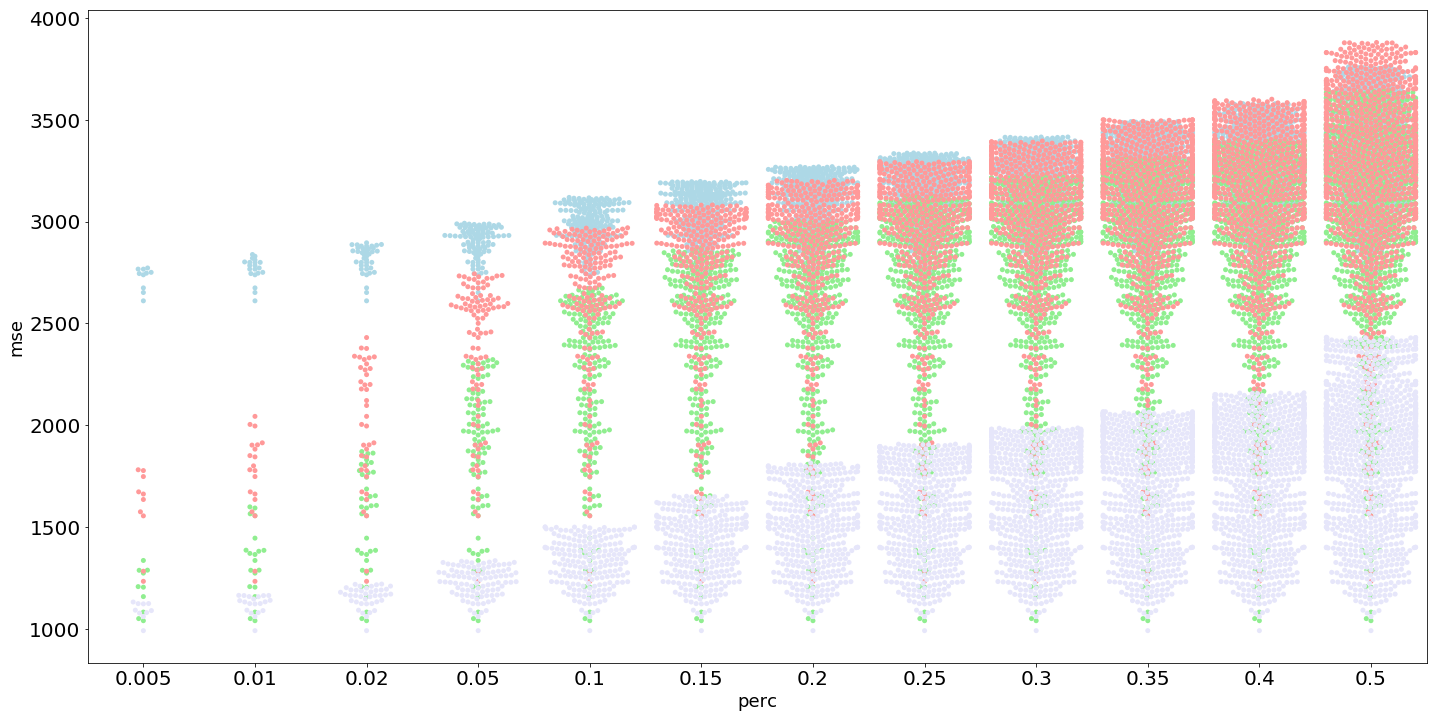

In [223]:
# mses_aN_1D_df = 

# percs = []
def get_mse_df(mses):
    sorted_mses = np.sort(mses)
    df = {'perc':[],'mse':[]}
    for p in [0.5,1,2,5,10,15,20,25,30,35,40,50]:
        perc = p/100
    #     percs.append(perc)
        top = round(perc*len(sorted_mses))
    #     df_ = {'perc': np.repeat(perc,top), 'mse': sorted_mses[:top]}
        df['perc'].append(np.repeat(perc,top))
        df['mse'].append(sorted_mses[:top])
    perc = np.concatenate(df['perc'],axis=0)
    mse = [x for y in df['mse'] for x in y]
    df = {'perc': perc,'mse':mse}
    df = pd.DataFrame(df)
    return df

mses_aN_1D_df = get_mse_df(last_mses_aN_1D)
mses_a1_1D_df = get_mse_df(last_mses_a1_1D)
mses_a2_1D_df = get_mse_df(last_mses_a2_1D)
mses_a3_1D_df = get_mse_df(last_mses_a3_1D)
# df.head()
# fig, ax = sns.subplots()
sns.swarmplot(x='perc',y='mse', data = mses_aN_1D_df, color='lightblue')
sns.swarmplot(x='perc',y='mse', data = mses_a1_1D_df, color='lightgreen')
sns.swarmplot(x='perc',y='mse', data = mses_a2_1D_df, color='#ff9999')
sns.swarmplot(x='perc',y='mse', data = mses_a3_1D_df, color='#E6E6FA')


# Plot all MSEs

In [52]:
# last_mses_a1_1D_branch
colors = ['#A9A9A9','#e84728','#1f77b4','#94ddaa']  
mses = [last_mses_a1_1D_branch, last_mses_a2_1D_branch, last_mses_a3_1D_branch, last_mses_a3s_1D_branch]        
plot_mses(['+MAPK', '+MAP2K', '+MAP3K', '+MAP3Ks'], mses, 0.5, colors, '0D')

NameError: name 'last_mses_a1_1D_branch' is not defined

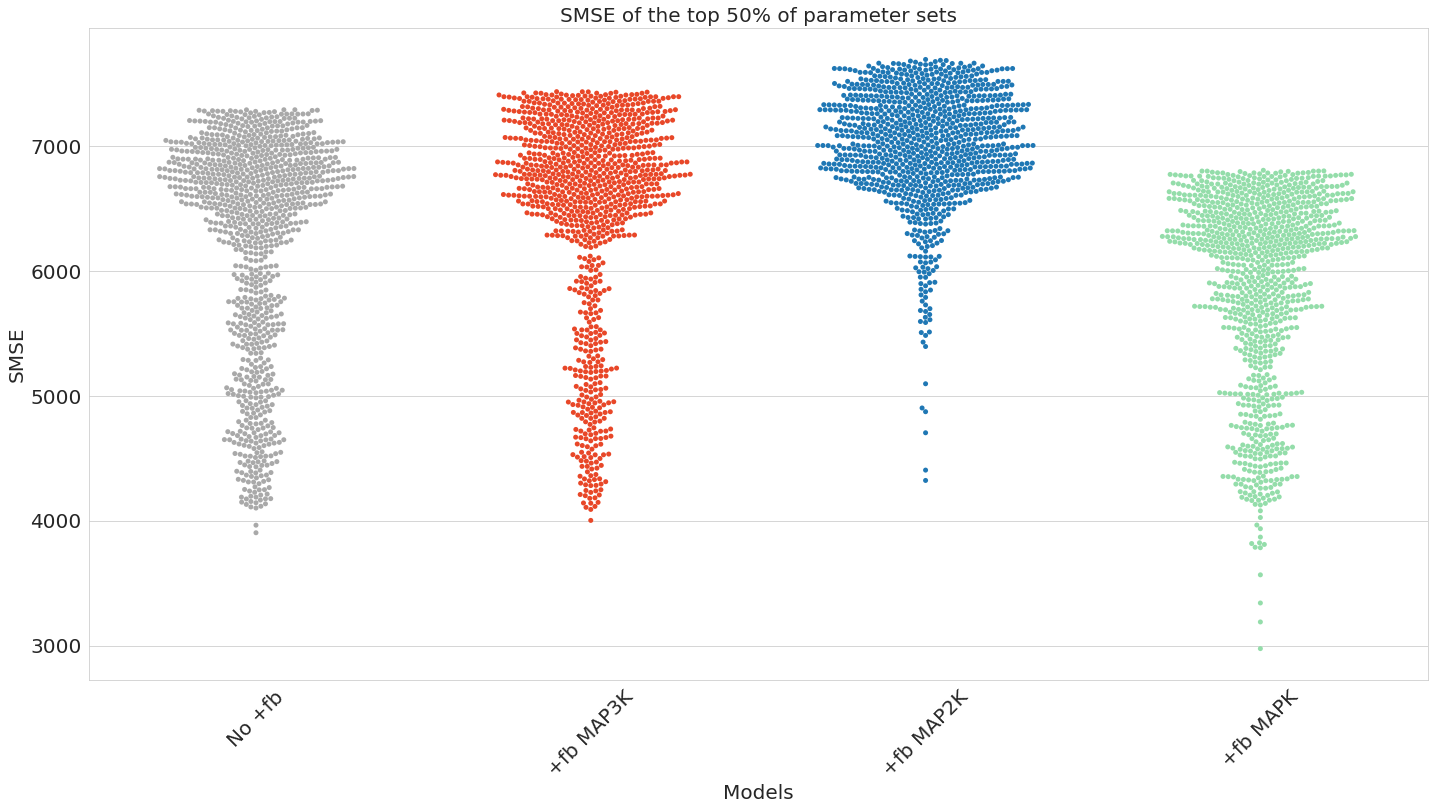

In [241]:
colors = ['#A9A9A9','#e84728','#1f77b4','#94ddaa']  
mses = [last_mses_aN_0D, last_mses_a3_0D, last_mses_a2_0D, last_mses_a1_0D]        
plot_mses(['No +fb', '+fb MAP3K', '+fb MAP2K', '+fb MAPK'], mses, 0.5, colors, '0D')

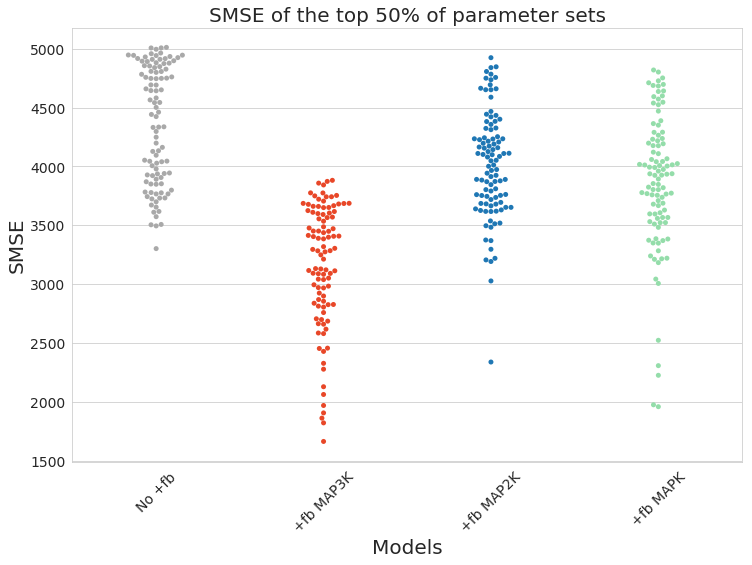

In [70]:
colors = ['#A9A9A9','#e84728','#1f77b4','#94ddaa']  
mses = [last_mses_aN_1D, last_mses_a3_1D, last_mses_a2_1D, last_mses_a1_1D]        
plot_mses(['No +fb', '+fb MAP3K', '+fb MAP2K', '+fb MAPK'], mses, 0.5, colors, '1D')

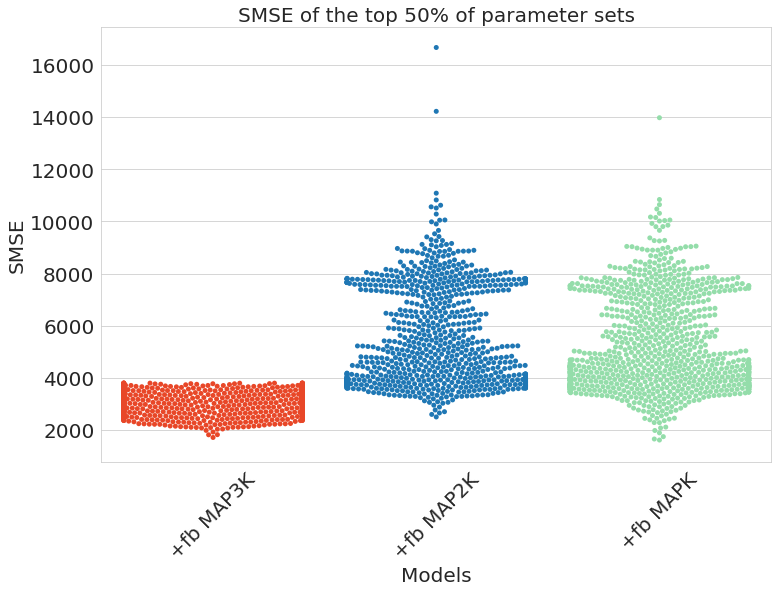

In [147]:
colors = ['#e84728','#1f77b4','#94ddaa']  
mses = [last_mses_a3_1D, last_mses_a2_1D, last_mses_a1_1D]        
plot_mses(['+fb MAP3K', '+fb MAP2K', '+fb MAPK'], mses, 0.5, colors, '1D')

In [ ]:
colors = ['#A9A9A9','#e84728','#1f77b4','#94ddaa']  
mses = [last_mses_an_2D, last_mses_a3_2D, last_mses_a2_2D, last_mses_a1_2D]        
plot_mses(['No +fb', '+fb MAP3K', '+fb MAP2K', '+fb MAPK'], mses, 0.25, colors)

In [41]:
plt.rcParams['figure.figsize'] = [24.0, 12.0]
rocket = sns.color_palette("rocket", 5)#[::-1][:4]
rocket = rocket.as_hex()
rocket[::-1][:4]*4
colors = ['#9e9e9e'] + rocket[::-1][:3] + ['#9e9e9e'] + rocket[::-1][:3] 

# param_col = sns.set_palette(colors)

mses = [last_mses_aN_0D, last_mses_a3_0D, last_mses_a2_0D, last_mses_a1_0D, 
        last_mses_aN_1D, last_mses_a3_1D, last_mses_a2_1D, last_mses_a1_1D] 
#         last_mses_an_2D, last_mses_a3_2D, last_mses_a2_2D, last_mses_a1_2D]        
plot_mses(['0D: None', '0D: +3K', '0D: +2K', '0D: +K',
           '1D: None', '1D: +3K', '1D: +2K', '1D: +K'],
#            '2D: None', '2D: +3K', '2D: +2K', '2D: +K'],
          mses, 0.05, colors,'mses_all')
# plt.savefig("C:/Users/sksuzuki/Documents/Research/presentations/lab_meetings/Figures/181024/mses_all.png",dpi=300)

NameError: name 'last_mses_aN_0D' is not defined

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


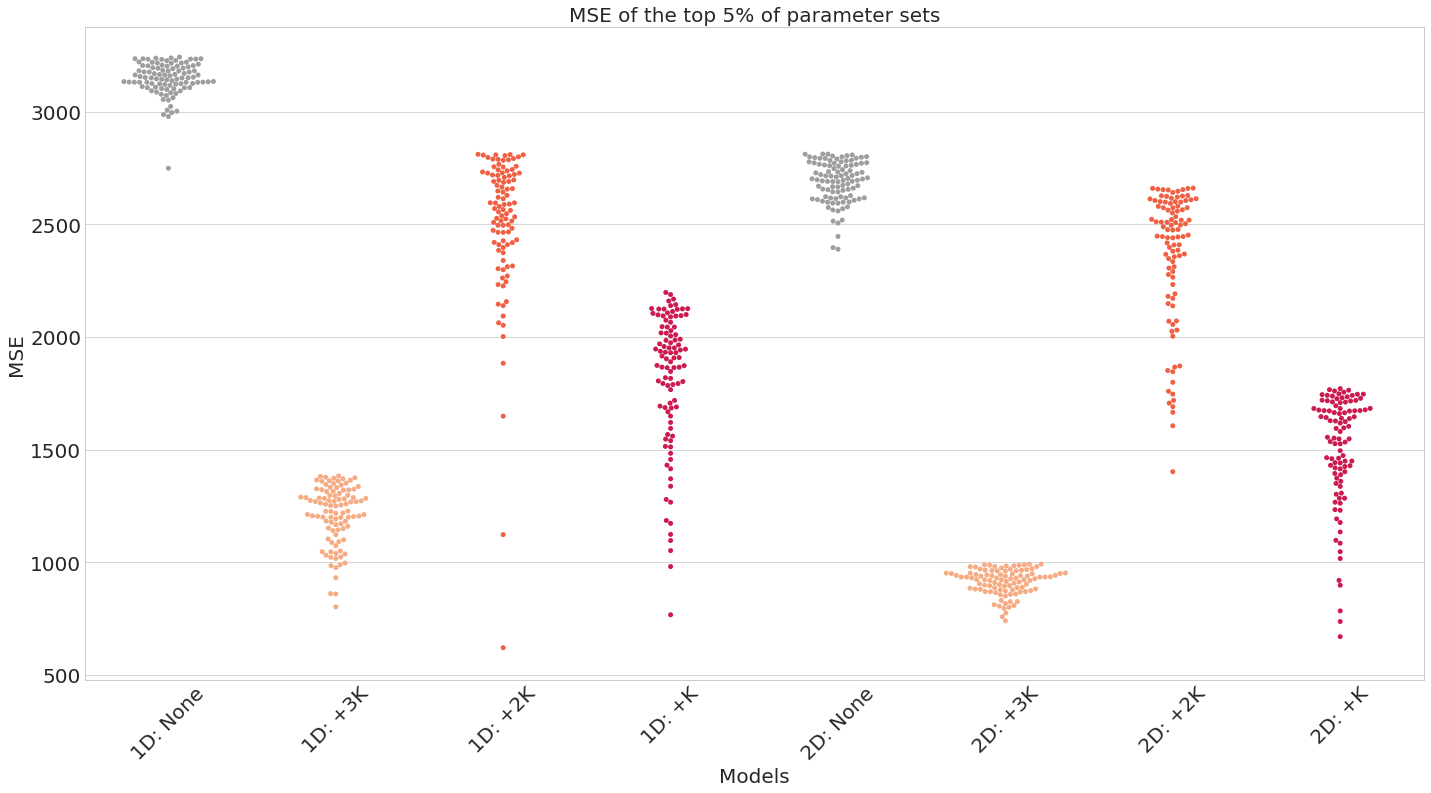

In [132]:
# plt.rcParams['figure.figsize'] = [24.0, 12.0]
# rocket = sns.color_palette("rocket", 5)#[::-1][:4]
# rocket = rocket.as_hex()
# rocket[::-1][:4]*4
colors = ['#9e9e9e'] + rocket[::-1][:3] + ['#9e9e9e'] + rocket[::-1][:3] 

# param_col = sns.set_palette(colors)

mses = [ 
        last_mses_an_1D, last_mses_a3_1D, last_mses_a2_1D, last_mses_a1_1D, 
        last_mses_an_2D, last_mses_a3_2D, last_mses_a2_2D, last_mses_a1_2D]        
plot_mses([
           '1D: None', '1D: +3K', '1D: +2K', '1D: +K',
           '2D: None', '2D: +3K', '2D: +2K', '2D: +K'], mses, 0.05, colors,'181024/mses_delay')